# Metaparameter Study of GreConDBiAKNNRecommender

This notebook tries to understand the relation between the parameters of
the GreConDBiAKNNRecommender and its performance and ultimately find the
a suggestion for the best parameters.

Copyright 2023 Bernardo C. Rodrigues

See COPYING file for license details

In [1]:
# Setup notebook

import random
import numpy as np
import evaluation.plot as plot

# Load the autoreload extension
%load_ext autoreload

# Set autoreload to reload all modules every time a cell is executed
%autoreload 2

# Call the function to customize the default template
plot.customize_default_template()

seed = 0
random.seed(seed)
np.random.seed(seed)

# Evaluation parameters
RELEVANCE_THRESHOLD = 4.0
NUMBER_OF_TOP_RECOMMENDATIONS = 20
REPEAT = 1 # Since GreConDKnn2 is deterministic, we don't need to repeat the experiment.

def get_number_of_combinations(parameters_grid):
    n_combinations = 1
    for parameter_values in parameters_grid.values():
        n_combinations *= len(parameter_values)
    print(f"Number of different combinations in the grid: {n_combinations}")

In [2]:
from dataset.jester import load_jester_folds

data, k_fold = load_jester_folds()

Already downloaded!. Nothing to do.


#### Randomized search

In [9]:
from surprise.model_selection import RandomizedSearchCV
from recommenders import grecond_recommender



parameters_grid = {
    "grecond_coverage": [0.1],
    "dataset_binarization_threshold": [5.0],
    "minimum_bicluster_sparsity": [None],
    "minimum_bicluster_coverage": [None],
    "minimum_bicluster_relative_size": [None],
    "user_binarization_threshold": [5.0],
    "number_of_top_k_biclusters": [None],
    "knn_k": [100],
    "knn_type": ["item"],
}
# parameters_grid = {
#     "grecond_coverage": [0.01, 0.2, 0.4, 0.6, 0.8, 1.0],
#     "dataset_binarization_threshold": [1.0, 3.0, 5.0],
#     "minimum_bicluster_sparsity": [None, 1e-07, 1e-05, 1e-03, 1e-01],
#     "minimum_bicluster_coverage": [None, 1e-07, 1e-05, 1e-03, 1e-01],
#     "minimum_bicluster_relative_size": [1e-07, 1e-05, 1e-03, 1e-01],
#     "user_binarization_threshold": [1.0, 3.0, 5.0],
#     "number_of_top_k_biclusters": [None, 1, 10, 100],
#     "knn_k": [1, 10, 100],
#     "knn_type": ["item"],
# }

get_number_of_combinations(parameters_grid)

search = RandomizedSearchCV(
    grecond_recommender.GreConDBiAKNNRecommender,
    parameters_grid,
    measures=["rmse"],
    cv=k_fold,
    n_jobs=-2,
    joblib_verbose=10,
    n_iter=1
)

search.fit(data)


print(search.best_params['rmse'])

print(search.best_score['rmse'])


Number of different combinations in the grid: 1


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-2)]: Done   3 out of   5 | elapsed:  1.7min remaining:  1.2min


{'grecond_coverage': 0.1, 'dataset_binarization_threshold': 5.0, 'minimum_bicluster_sparsity': None, 'minimum_bicluster_coverage': None, 'minimum_bicluster_relative_size': None, 'user_binarization_threshold': 5.0, 'number_of_top_k_biclusters': None, 'knn_k': 100, 'knn_type': 'item'}
5.508036815769828


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  1.8min finished


Best parameters on randomized search:
```python
{
    'grecond_coverage': 0.6, 
    'dataset_binarization_threshold': 3.0, 
    'minimum_bicluster_sparsity': 0.001, 
    'minimum_bicluster_coverage': None, 
    'minimum_bicluster_relative_size': 1e-07, 
    'user_binarization_threshold': 3.0, 
    'number_of_top_k_biclusters': None, 
    'knn_k': 100, 
    'knn_type': 'item'
}
```

#### Local grid search

5.518524504150936


In [ ]:
from surprise.model_selection import GridSearchCV
from recommenders import grecond_recommender
from dataset.movie_lens import load_ml_1m_folds

data, k_fold = load_ml_1m_folds()

parameters_grid = {
    "grecond_coverage": [0.6],
    "dataset_binarization_threshold": [3.0, 4.0],
    "minimum_bicluster_sparsity": [None, 1e-03],
    "minimum_bicluster_coverage": [None, 1e-07],
    "minimum_bicluster_relative_size": [None, 1e-07],
    "user_binarization_threshold": [3.0, 4.0],
    "number_of_top_k_biclusters": [None, 10],
    "knn_k": [100],
    "knn_type": ["item"],
}

get_number_of_combinations(parameters_grid)

search = GridSearchCV(
    algo_class=grecond_recommender.GreConDBiAKNNRecommender,
    param_grid=parameters_grid,
    measures=["rmse"],
    cv=k_fold,
    n_jobs=-1,
    joblib_verbose=10,
)

search.fit(data)

print(search.best_params['rmse'])

Best parameters on randomized search:
```python
{
    'grecond_coverage': 0.6,
    'dataset_binarization_threshold': 3.0,
    'minimum_bicluster_sparsity': None,
    'minimum_bicluster_coverage': None,
    'minimum_bicluster_relative_size': None,
    'user_binarization_threshold': 3.0,
    'number_of_top_k_biclusters': None,
    'knn_k': 100,
    'knn_type': 'item'
}
```

#### Sweeps around best parameters

##### grecond_coverage

In [ ]:
import json
from evaluation import threads
from recommenders import grecond_recommender
from dataset.movie_lens import load_ml_1m_folds
from dataset.movie_lens import resolve_folds

data, k_fold = load_ml_1m_folds()

best_params_user = {
    'grecond_coverage': 0.6,
    'dataset_binarization_threshold': 3.0,
    'minimum_bicluster_sparsity': None,
    'minimum_bicluster_coverage': None,
    'minimum_bicluster_relative_size': None,
    'user_binarization_threshold': 3.0,
    'number_of_top_k_biclusters': None,
    'knn_k': 100,
    'knn_type': 'item'
 }

folds = resolve_folds(data, k_fold)

grecond_coverages = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

recommender_variations = [
    threads.RecommenderVariation(
        str(coverage),
        grecond_recommender.GreConDBiAKNNRecommender(
            grecond_coverage=coverage,
            dataset_binarization_threshold=best_params_user["dataset_binarization_threshold"],
            minimum_bicluster_sparsity=best_params_user["minimum_bicluster_sparsity"],
            minimum_bicluster_coverage=best_params_user["minimum_bicluster_coverage"],
            minimum_bicluster_relative_size=best_params_user["minimum_bicluster_relative_size"],
            knn_type=best_params_user["knn_type"],
            user_binarization_threshold=best_params_user["user_binarization_threshold"],
            number_of_top_k_biclusters=best_params_user["number_of_top_k_biclusters"],
            knn_k=best_params_user["knn_k"],
        ),
    )
    for coverage in grecond_coverages
]

from evaluation.threads import grecond_biaknn_benchmark_thread

results = plot.benchmark(
    folds,
    recommender_variations,
    [],
    repeats=REPEAT,
    relevance_threshold=RELEVANCE_THRESHOLD,
    number_of_top_recommendations=NUMBER_OF_TOP_RECOMMENDATIONS,
    benchmark_thread=grecond_biaknn_benchmark_thread,
    thread_count=8
)

with open('GreConD_IBPAKNN_sweep_grecond_coverage.results', 'w') as file_object:
    json.dump(results, file_object, indent=4)

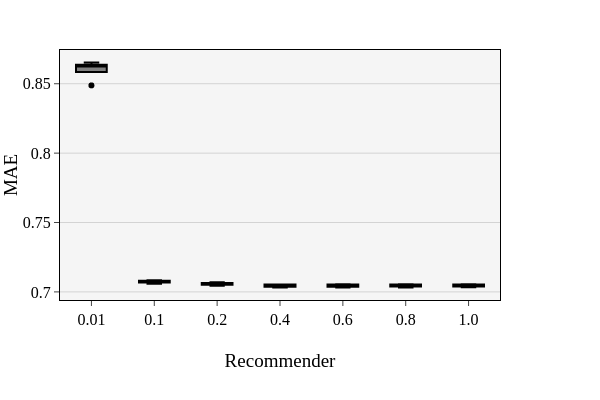

  Recommender      Mean  Standard Deviation      Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01  0.860251            0.005856  3.429441e-05  0.848802  0.865305  0.862346  0.861625  0.863179     0.859294     0.865510 -1.329434  0.049520
1         0.1  0.707280            0.000833  6.945248e-07  0.705920  0.708415  0.707255  0.707015  0.707794     0.705848     0.708961 -0.322954 -0.862612
2         0.2  0.705672            0.000849  7.214377e-07  0.704372  0.706875  0.705469  0.705385  0.706260     0.704072     0.707573 -0.093755 -1.047630
3         0.4  0.704484            0.000841  7.067345e-07  0.703169  0.705413  0.704618  0.703941  0.705277     0.701937     0.707281 -0.379440 -1.311962
4         0.6  0.704496            0.000827  6.833542e-07  0.703204  0.705432  0.704654  0.703952  0.705239     0.702022     0.707170 -0.383751 -1.310917
5         0.8  0.704548            0.000828  6.850840e-07  0.703240  0.70545

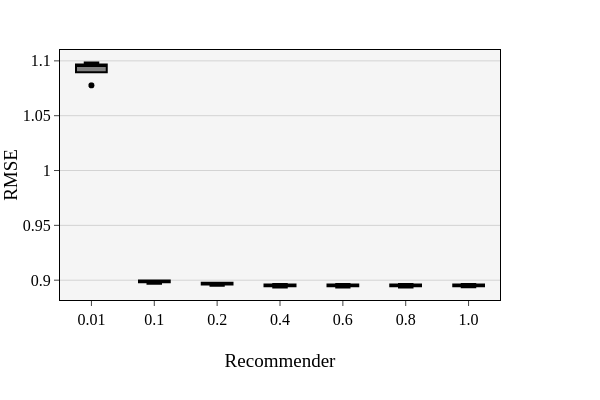

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01  1.092215            0.007448  0.000055  1.077660  1.098502  1.095265  1.093589  1.096061     1.089881     1.099768 -1.330044  0.038993
1         0.1  0.898738            0.001074  0.000001  0.896812  0.899808  0.898915  0.898508  0.899648     0.896796     0.901360 -0.835411 -0.630338
2         0.2  0.896729            0.001035  0.000001  0.894900  0.897756  0.896719  0.896577  0.897692     0.894905     0.899364 -0.748655 -0.701230
3         0.4  0.895202            0.001098  0.000001  0.893327  0.896467  0.895578  0.894712  0.895928     0.892887     0.897753 -0.643285 -0.895037
4         0.6  0.895212            0.001083  0.000001  0.893344  0.896419  0.895624  0.894739  0.895936     0.892943     0.897732 -0.696374 -0.868447
5         0.8  0.895258            0.001082  0.000001  0.893398  0.896493  0.895681  0.894781  0.895

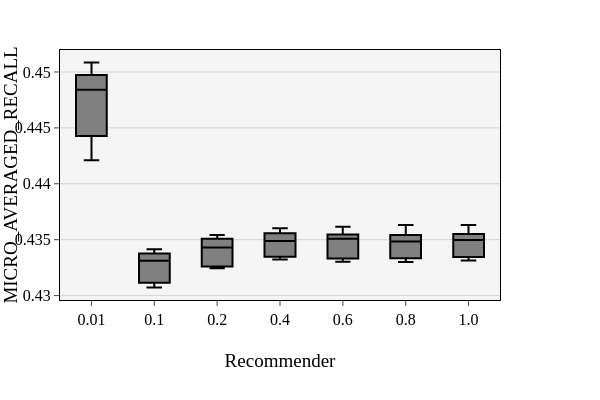

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01  0.447144            0.003171  0.000010  0.442101  0.450847  0.448411  0.444997  0.449365     0.438444     0.455917 -0.466438 -1.254526
1         0.1  0.432585            0.001338  0.000002  0.430724  0.434155  0.433122  0.431300  0.433627     0.427810     0.437117 -0.285903 -1.623836
2         0.2  0.433952            0.001205  0.000001  0.432436  0.435413  0.434294  0.432652  0.434965     0.429182     0.438434 -0.169645 -1.696846
3         0.4  0.434618            0.001072  0.000001  0.433226  0.436020  0.434876  0.433550  0.435416     0.430750     0.438216 -0.102092 -1.588363
4         0.6  0.434583            0.001184  0.000001  0.433018  0.436167  0.435076  0.433410  0.435243     0.430662     0.437991 -0.127673 -1.532030
5         0.8  0.434543            0.001194  0.000001  0.433009  0.436315  0.434842  0.433437  0.435

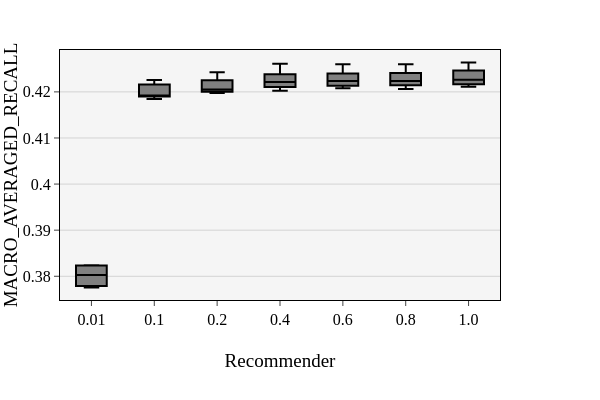

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01  0.380098            0.002055  0.000004  0.377563  0.382373  0.380253  0.377971  0.382329     0.371435     0.388866 -0.069564 -1.730571
1         0.1  0.420134            0.001539  0.000002  0.418443  0.422556  0.419194  0.419186  0.421289     0.416031     0.424445  0.507117 -1.361170
2         0.2  0.421322            0.001655  0.000003  0.419783  0.424279  0.420502  0.420094  0.421950     0.417310     0.424734  0.886164 -0.732050
3         0.4  0.422575            0.001985  0.000004  0.420265  0.426087  0.422134  0.421314  0.423073     0.418677     0.425710  0.742983 -0.639057
4         0.6  0.422795            0.001817  0.000003  0.420806  0.426011  0.422377  0.421470  0.423313     0.418705     0.426077  0.771546 -0.689226
5         0.8  0.422823            0.001838  0.000003  0.420605  0.426003  0.422356  0.421705  0.423

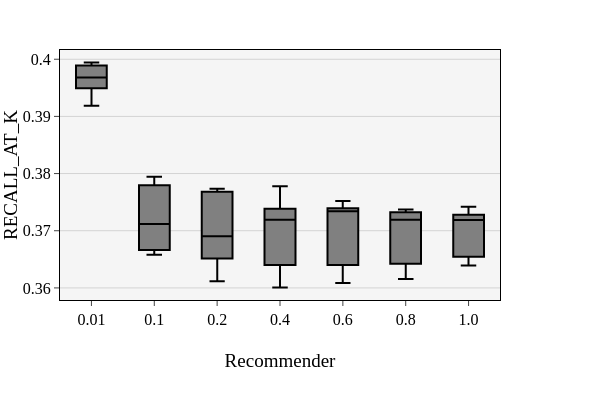

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01  0.396548            0.002663  0.000007  0.391856  0.399429  0.396801  0.395937  0.398718     0.391765     0.402890 -0.734878 -0.710023
1         0.1  0.372160            0.005486  0.000030  0.365818  0.379435  0.371180  0.366875  0.377491     0.350950     0.393416  0.161109 -1.673062
2         0.2  0.370132            0.006158  0.000038  0.361168  0.377335  0.369055  0.366443  0.376659     0.351120     0.391982 -0.102827 -1.449191
3         0.4  0.369533            0.006163  0.000038  0.360072  0.377787  0.371924  0.365347  0.372536     0.354564     0.383319 -0.271176 -1.187005
4         0.6  0.369600            0.005624  0.000032  0.360837  0.375182  0.373393  0.365074  0.373515     0.352411     0.386178 -0.536465 -1.454893
5         0.8  0.369093            0.004854  0.000024  0.361576  0.373735  0.371943  0.365129  0.373

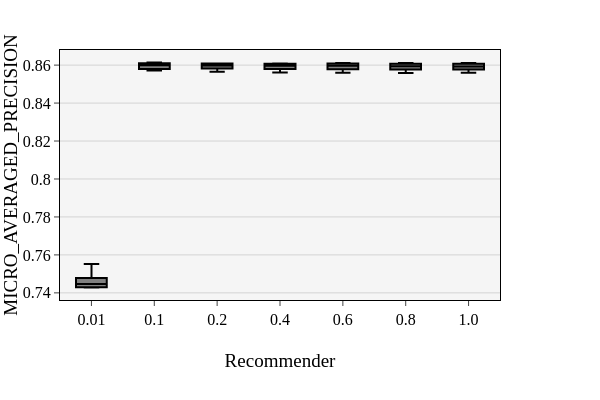

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01  0.746226            0.004618  0.000021  0.742824  0.755246  0.744701  0.742956  0.745403     0.739284     0.749075  1.331012  0.022700
1         0.1  0.859514            0.001596  0.000003  0.857210  0.861379  0.859880  0.858171  0.860930     0.854031     0.865069 -0.260057 -1.532298
2         0.2  0.859367            0.001597  0.000003  0.856556  0.860862  0.859778  0.858809  0.860827     0.855781     0.863855 -0.777935 -0.783183
3         0.4  0.859186            0.001713  0.000003  0.856161  0.860911  0.859627  0.858618  0.860612     0.855627     0.863603 -0.784785 -0.752169
4         0.6  0.859191            0.001850  0.000003  0.855989  0.861158  0.859614  0.858482  0.860712     0.855138     0.864056 -0.694049 -0.854250
5         0.8  0.859056            0.001855  0.000003  0.855878  0.861125  0.859419  0.858328  0.860

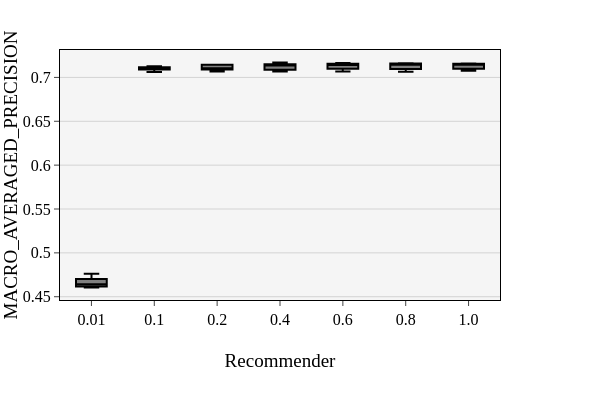

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01  0.466184            0.005589  0.000031  0.460517  0.476094  0.464104  0.462003  0.468200     0.452707     0.477496  0.821965 -0.741902
1         0.1  0.710093            0.002165  0.000005  0.706197  0.712718  0.710206  0.710095  0.711251     0.708362     0.712984 -0.779501 -0.450563
2         0.2  0.711147            0.002928  0.000009  0.706854  0.714568  0.710419  0.709608  0.714285     0.702593     0.721300 -0.097047 -1.424117
3         0.4  0.712236            0.003710  0.000014  0.706739  0.717005  0.713715  0.709274  0.714449     0.701511     0.722212 -0.272679 -1.378214
4         0.6  0.712728            0.003513  0.000012  0.706758  0.716556  0.714077  0.710972  0.715279     0.704513     0.721738 -0.660249 -0.977065
5         0.8  0.712626            0.003630  0.000013  0.706565  0.716148  0.714316  0.710451  0.715

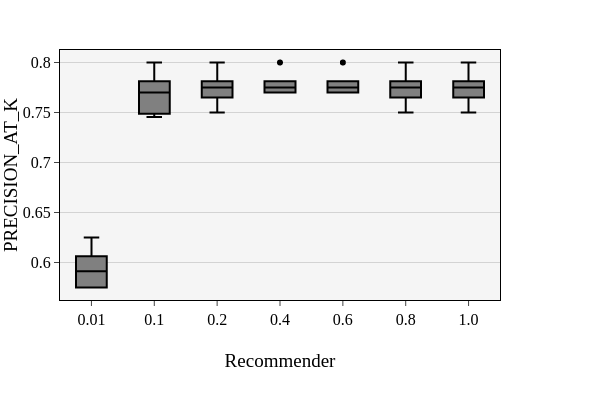

  Recommender      Mean  Standard Deviation  Variance       Min    Max    Median     Q1     Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01  0.593235            0.018569  0.000345  0.575000  0.625  0.591176  0.575  0.600       0.5375       0.6375  0.631721 -0.911861
1         0.1  0.768091            0.019541  0.000382  0.745455  0.800  0.770000  0.750  0.775       0.7125       0.8125  0.410265 -1.067799
2         0.2  0.774000            0.015937  0.000254  0.750000  0.800  0.775000  0.770  0.775       0.7625       0.7825  0.182308 -0.554064
3         0.4  0.778000            0.011225  0.000126  0.770000  0.800  0.775000  0.770  0.775       0.7625       0.7825  1.353275  0.056311
4         0.6  0.778000            0.011225  0.000126  0.770000  0.800  0.775000  0.770  0.775       0.7625       0.7825  1.353275  0.056311
5         0.8  0.774000            0.015937  0.000254  0.750000  0.800  0.775000  0.770  0.775       0.7625       0.7825  0.182308 -0.554064
6         1.0

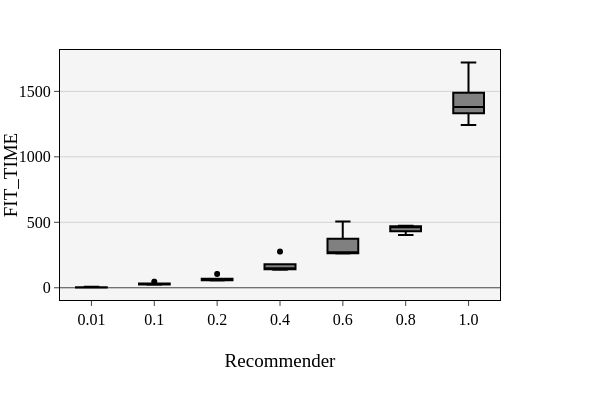

  Recommender         Mean  Standard Deviation      Variance          Min          Max       Median           Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01     3.467965            1.864050      3.474681     2.100280     6.985652     2.293306     2.182406     3.778183    -0.211258     6.171847  1.150363 -0.328636
1         0.1    29.892800            8.575455     73.538421    23.720424    46.754478    26.066567    24.578877    28.343654    18.931712    33.990820  1.379299  0.080850
2         0.2    66.718474           19.391529    376.031404    56.482423   105.490450    57.086668    56.692131    57.840696    54.969283    59.563545  1.497867  0.247125
3         0.4   169.099095           53.847055   2899.505329   137.493647   276.619071   142.375202   141.853187   147.154369   133.901412   155.106143  1.487915  0.233851
4         0.6   326.645404           93.506891   8743.538633   262.740156   506.605664   269.521668   263.649567   330.709968   163.058965  

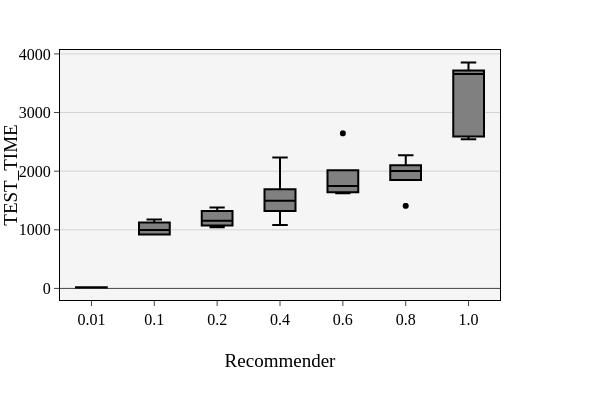

  Recommender         Mean  Standard Deviation       Variance          Min          Max       Median           Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01    17.794950            1.343740       1.805638    15.762208    19.838508    17.923342    17.136344    18.314348    15.369339    20.081353 -0.000713 -0.866779
1         0.1  1024.965573          102.503304   10506.927374   920.218813  1176.217498   996.671870   921.734272  1109.985411   639.357562  1392.362121  0.334773 -1.532184
2         0.2  1191.815926          128.581712   16533.256736  1043.598481  1379.810918  1153.383082  1081.878373  1300.408774   754.082770  1628.204376  0.308871 -1.522768
3         0.4  1545.313527          377.674776  142638.236180  1083.661837  2234.718059  1495.709066  1399.400686  1513.077988  1228.884731  1683.593943  0.839076 -0.328460
4         0.6  1894.288000          381.647447  145654.774148  1623.616876  2645.501196  1749.043899  1644.841905  1808.436124  1399.45

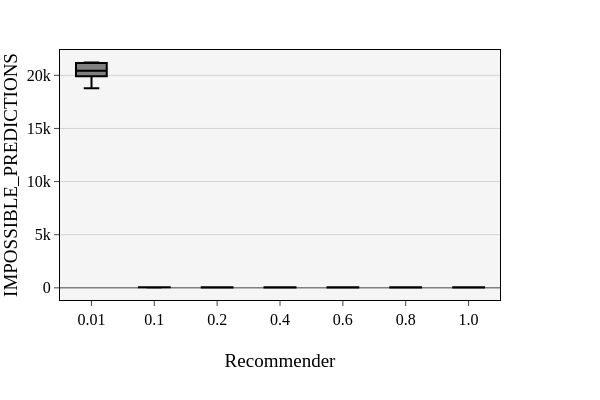

  Recommender     Mean  Standard Deviation   Variance    Min    Max   Median       Q1       Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01  20365.8          871.136132  758878.16  18785  21204  20438.0  20275.0  21127.0      18997.0      22405.0 -0.883612 -0.543275
1         0.1     54.2            7.082372      50.16     43     62     58.0     49.0     59.0         34.0         74.0 -0.509791 -1.338076
2         0.2     46.4            9.604166      92.24     33     58     46.0     39.0     56.0         13.5         81.5 -0.082575 -1.546339
3         0.4     46.4            9.604166      92.24     33     58     46.0     39.0     56.0         13.5         81.5 -0.082575 -1.546339
4         0.6     46.4            9.604166      92.24     33     58     46.0     39.0     56.0         13.5         81.5 -0.082575 -1.546339
5         0.8     46.4            9.604166      92.24     33     58     46.0     39.0     56.0         13.5         81.5 -0.082575 -1.546339
6         1.0

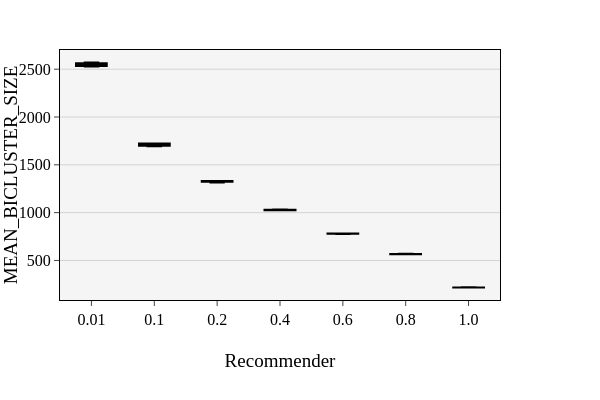

  Recommender         Mean  Standard Deviation    Variance          Min          Max       Median           Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01  2549.400000           15.653754  245.040000  2528.333333  2570.000000  2555.000000  2534.333333  2559.333333  2496.833333  2596.833333 -0.149753 -1.536774
1         0.1  1712.290385           12.129419  147.122817  1694.650000  1723.512821  1720.051282  1700.725000  1722.512821  1668.043269  1755.194551 -0.458084 -1.658954
2         0.2  1325.981382            5.260855   27.676594  1315.980392  1330.861386  1326.901961  1326.519608  1329.643564  1321.833673  1334.329499 -1.145627 -0.192729
3         0.4  1028.573972            3.061019    9.369839  1024.530686  1033.402878  1028.848375  1026.234875  1029.853047  1020.807619  1035.280303  0.249758 -1.078169
4         0.6   780.221051            2.091953    4.376268   777.043478   782.554955   779.709386   779.292948   782.504488   774.475636   787.321799 

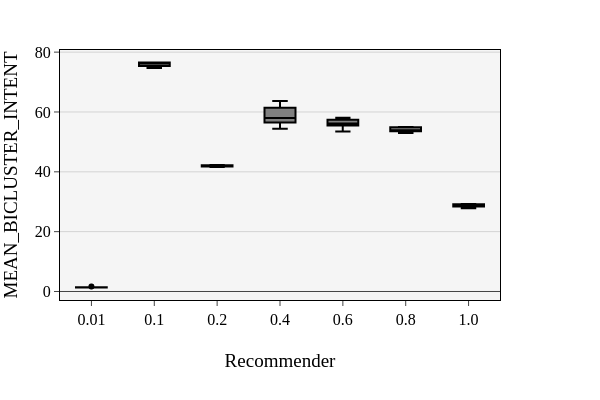

  Recommender       Mean  Standard Deviation  Variance        Min        Max     Median         Q1         Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01   1.400000            0.133333  0.017778   1.333333   1.666667   1.333333   1.333333   1.333333     1.333333     1.333333  1.500000  0.250000
1         0.1  75.962436            0.716450  0.513300  74.700000  76.538462  76.435897  75.625000  76.512821    74.293269    77.844551 -0.862770 -0.870713
2         0.2  41.996894            0.237087  0.056210  41.627451  42.257426  42.127451  41.813725  42.158416    41.296690    42.675451 -0.486941 -1.396420
3         0.4  58.789687            3.151528  9.932131  54.433692  63.676259  57.974729  57.185053  60.678700    51.944583    65.919171  0.230651 -1.073884
4         0.6  56.189195            1.558718  2.429600  53.436266  58.075676  56.132246  56.111913  57.189873    54.494973    58.806814 -0.694385 -0.590924
5         0.8  54.079548            0.766170  0.587017  52.94540

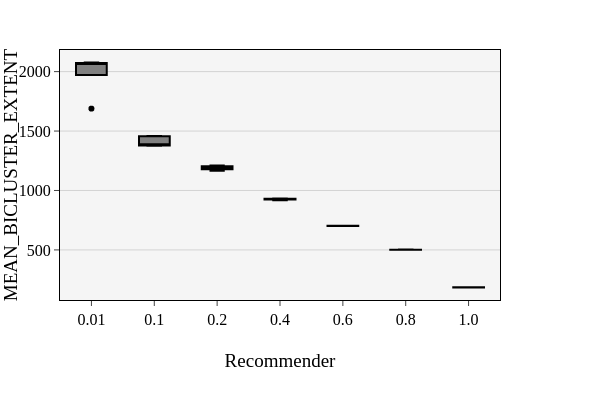

  Recommender         Mean  Standard Deviation      Variance          Min          Max       Median           Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01  1993.200000          152.323865  23202.560000  1688.666667  2076.666667  2066.000000  2064.666667  2070.000000  2056.666667  2078.000000 -1.497170  0.246277
1         0.1  1411.727821           36.491682   1331.642840  1377.256410  1457.871795  1388.900000  1380.175000  1454.435897  1268.783654  1565.827244  0.378157 -1.811754
2         0.2  1191.500835           15.301200    234.126725  1166.362745  1209.861386  1195.274510  1183.441176  1202.564356  1154.756407  1231.249126 -0.491927 -1.057569
3         0.4   926.962585            4.645653     21.582094   918.811388   932.776173   928.143885   925.866426   929.215054   920.843484   934.237995 -0.664924 -0.601492
4         0.6   702.482789            0.865337      0.748808   701.315315   703.818671   702.643116   701.810127   702.826715   700.285244  

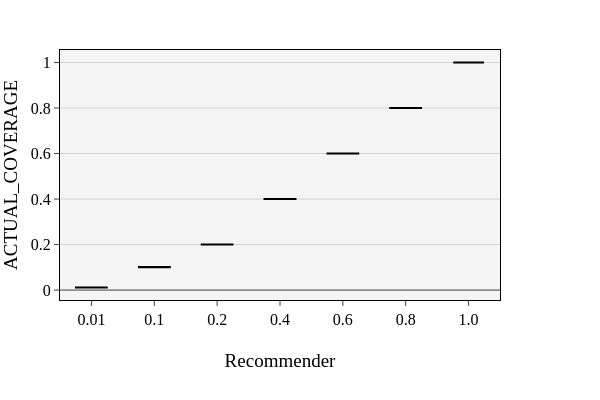

  Recommender      Mean  Standard Deviation      Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        0.01  0.011429            0.000069  4.756471e-09  0.011337  0.011519  0.011455  0.011362  0.011473     0.011196     0.011638 -0.157471 -1.548261
1         0.1  0.100709            0.000568  3.226041e-07  0.100163  0.101561  0.100323  0.100281  0.101216     0.098879     0.102619  0.491926 -1.583085
2         0.2  0.200356            0.000087  7.507066e-09  0.200227  0.200498  0.200349  0.200334  0.200371     0.200279     0.200426  0.208022 -0.575996
3         0.4  0.400415            0.000223  4.951587e-08  0.400136  0.400688  0.400414  0.400201  0.400638     0.399547     0.401292 -0.007516 -1.682350
4         0.6  0.600202            0.000124  1.543693e-08  0.600003  0.600364  0.600192  0.600154  0.600297     0.599940     0.600511 -0.302217 -1.036393
5         0.8  0.800110            0.000047  2.234139e-09  0.800049  0.80016

/home/brodrigues/Projects/RecoBinaPs/evaluation/plot.py:334: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/home/brodrigues/Projects/RecoBinaPs/evaluation/plot.py:335: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



In [3]:
import json
from evaluation.threads import GRECOND_BIAKNN_METIC_NAMES

with open('GreConD_IBPAKNN_sweep_grecond_coverage.results', 'r') as file_object:
    results = json.load(file_object)

for metric_name in GRECOND_BIAKNN_METIC_NAMES:
    plot.plot_metric_box_plot(metric_name, results)
    print(plot.get_result_table(metric_name, results))

In [ ]:
import json
from evaluation import threads
from recommenders import grecond_recommender
from dataset.movie_lens import load_ml_1m_folds
from dataset.movie_lens import resolve_folds

data, k_fold = load_ml_1m_folds()

best_params_user = {
    'grecond_coverage': 0.1,
    'dataset_binarization_threshold': 3.0,
    'minimum_bicluster_sparsity': None,
    'minimum_bicluster_coverage': None,
    'minimum_bicluster_relative_size': None,
    'user_binarization_threshold': 3.0,
    'number_of_top_k_biclusters': None,
    'knn_k': 100,
    'knn_type': 'item'
 }

folds = resolve_folds(data, k_fold)

dataset_binarization_thresholds = [1.0, 2.0, 3.0, 4.0, 5.0]

recommender_variations = [
    threads.RecommenderVariation(
        str(dataset_binarization_threshold),
        grecond_recommender.GreConDBiAKNNRecommender(
            grecond_coverage=best_params_user['grecond_coverage'],
            dataset_binarization_threshold=dataset_binarization_threshold,
            minimum_bicluster_sparsity=best_params_user["minimum_bicluster_sparsity"],
            minimum_bicluster_coverage=best_params_user["minimum_bicluster_coverage"],
            minimum_bicluster_relative_size=best_params_user["minimum_bicluster_relative_size"],
            knn_type=best_params_user["knn_type"],
            user_binarization_threshold=best_params_user["user_binarization_threshold"],
            number_of_top_k_biclusters=best_params_user["number_of_top_k_biclusters"],
            knn_k=best_params_user["knn_k"],
        ),
    )
    for dataset_binarization_threshold in dataset_binarization_thresholds
]

from evaluation.threads import grecond_biaknn_benchmark_thread

results = plot.benchmark(
    folds,
    recommender_variations,
    [],
    repeats=REPEAT,
    relevance_threshold=RELEVANCE_THRESHOLD,
    number_of_top_recommendations=NUMBER_OF_TOP_RECOMMENDATIONS,
    benchmark_thread=grecond_biaknn_benchmark_thread,
    thread_count=8
)

with open('GreConD_IBPAKNN_sweep_dataset_binarization_threshold.results', 'w') as file_object:
    json.dump(results, file_object, indent=4)

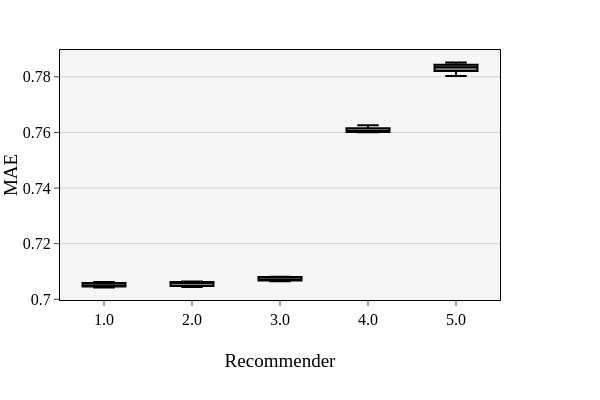

  Recommender      Mean  Standard Deviation      Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.705138            0.000728  5.293203e-07  0.704246  0.706189  0.704763  0.704707  0.705787     0.703088     0.707406  0.305328 -1.513858
1         2.0  0.705574            0.000780  6.085879e-07  0.704438  0.706440  0.706040  0.704857  0.706096     0.702998     0.707955 -0.397104 -1.589747
2         3.0  0.707323            0.000626  3.913044e-07  0.706485  0.708079  0.707156  0.706888  0.708006     0.705211     0.709683  0.061883 -1.598216
3         4.0  0.760865            0.000939  8.813383e-07  0.760043  0.762602  0.760388  0.760204  0.761088     0.758877     0.762416  1.038474 -0.476862
4         5.0  0.783121            0.001628  2.649364e-06  0.780274  0.785148  0.783417  0.782748  0.784018     0.780843     0.785923 -0.652008 -0.627257


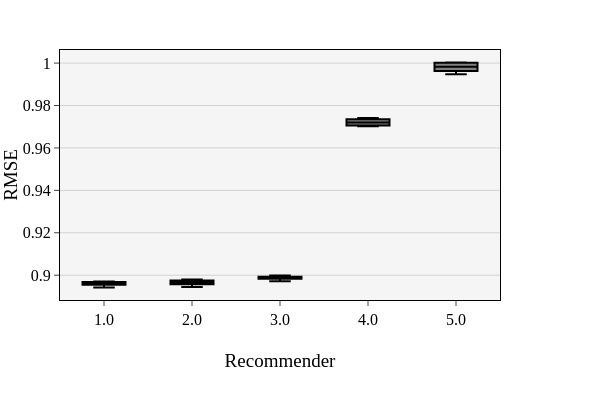

  Recommender      Mean  Standard Deviation      Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.895989            0.000997  9.941347e-07  0.894201  0.897084  0.895976  0.895938  0.896746     0.894727     0.897957 -0.801035 -0.574956
1         2.0  0.896526            0.001231  1.514725e-06  0.894401  0.898020  0.896632  0.896207  0.897372     0.894460     0.899119 -0.610975 -0.743459
2         3.0  0.898775            0.000905  8.193606e-07  0.897132  0.899890  0.898953  0.898778  0.899123     0.898261     0.899640 -0.810680 -0.361270
3         4.0  0.972067            0.001491  2.222979e-06  0.970225  0.974064  0.972007  0.970654  0.973384     0.966559     0.977479  0.071682 -1.607527
4         5.0  0.998062            0.002091  4.372591e-06  0.994799  1.000282  0.998311  0.996741  1.000178     0.991584     1.005335 -0.363545 -1.318220


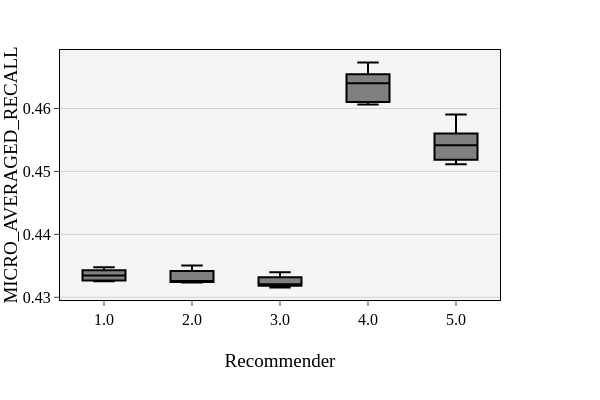

  Recommender      Mean  Standard Deviation      Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.433523            0.000843  7.103844e-07  0.432559  0.434767  0.433453  0.432694  0.434142     0.430521     0.436314  0.232776 -1.463611
1         2.0  0.433264            0.001050  1.103117e-06  0.432334  0.435063  0.432594  0.432477  0.433852     0.430415     0.435914  0.765278 -1.039428
2         3.0  0.432485            0.000867  7.516530e-07  0.431549  0.433974  0.432070  0.431925  0.432907     0.430452     0.434381  0.708824 -0.930880
3         4.0  0.463587            0.002451  6.007791e-06  0.460638  0.467310  0.464015  0.461172  0.464798     0.455733     0.470237  0.187015 -1.315608
4         5.0  0.454289            0.002753  7.576963e-06  0.451122  0.459033  0.454167  0.452100  0.455024     0.447713     0.459410  0.622421 -0.803827


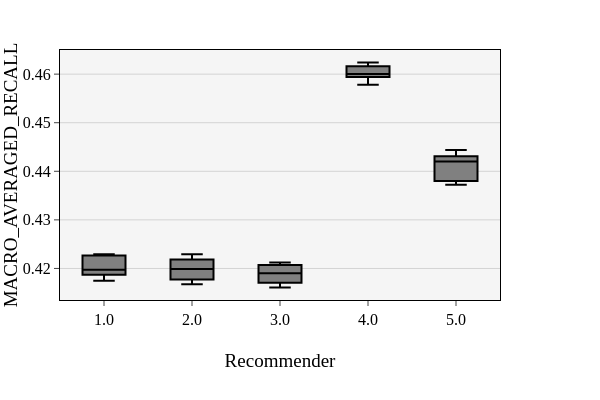

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.420371            0.002087  0.000004  0.417486  0.422946  0.419712  0.419134  0.422576     0.413972     0.427739  0.035299 -1.530415
1         2.0  0.419826            0.002233  0.000005  0.416745  0.422900  0.419903  0.418063  0.421522     0.412874     0.426710 -0.015256 -1.412656
2         3.0  0.418841            0.001918  0.000004  0.416078  0.421233  0.418999  0.417368  0.420526     0.412631     0.425262 -0.164626 -1.465424
3         4.0  0.460314            0.001545  0.000002  0.457807  0.462393  0.460033  0.459959  0.461376     0.457833     0.463501 -0.304551 -0.914436
4         5.0  0.440901            0.002726  0.000007  0.437219  0.444384  0.442003  0.438231  0.442669     0.431574     0.449325 -0.195965 -1.576656


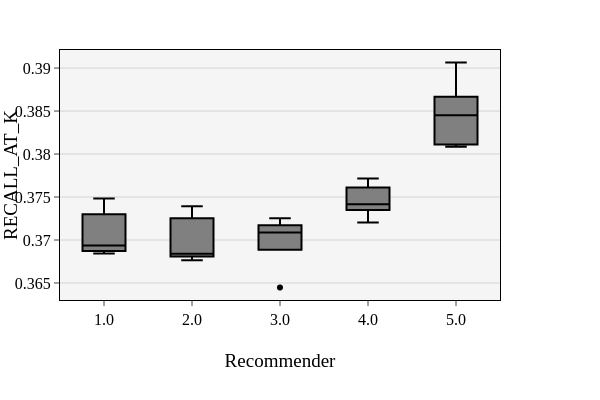

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.370769            0.002462  0.000006  0.368423  0.374835  0.369371  0.368838  0.372378     0.363528     0.377688  0.650444 -1.214572
1         2.0  0.370054            0.002483  0.000006  0.367649  0.373935  0.368401  0.368240  0.372046     0.362531     0.377755  0.547544 -1.452717
2         3.0  0.369931            0.002825  0.000008  0.364475  0.372529  0.370869  0.370321  0.371460     0.368613     0.373168 -1.246300 -0.052558
3         4.0  0.374616            0.001733  0.000003  0.372043  0.377155  0.374160  0.373962  0.375762     0.371263     0.378461  0.017108 -1.063037
4         5.0  0.384504            0.003547  0.000013  0.380843  0.390646  0.384505  0.381177  0.385350     0.374919     0.391608  0.656060 -0.819779


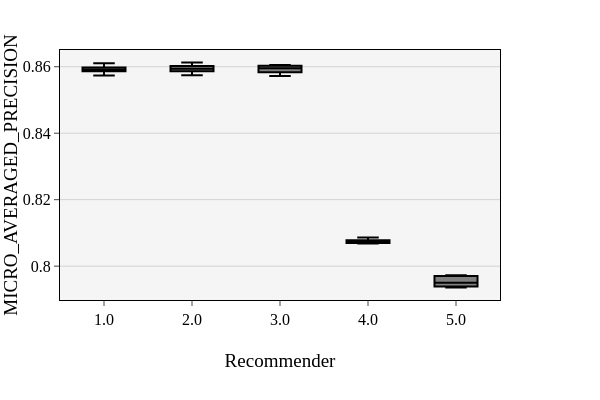

  Recommender      Mean  Standard Deviation      Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.859183            0.001161  1.347436e-06  0.857360  0.861023  0.859110  0.859106  0.859319     0.858788     0.859637  0.020251 -0.521716
1         2.0  0.859396            0.001240  1.538820e-06  0.857429  0.861275  0.859395  0.859059  0.859823     0.857914     0.860968 -0.098993 -0.679636
2         3.0  0.859243            0.001200  1.439866e-06  0.857192  0.860508  0.859553  0.858711  0.860250     0.856403     0.862559 -0.659675 -0.938903
3         4.0  0.807483            0.000634  4.016960e-07  0.806840  0.808648  0.807454  0.806995  0.807475     0.806274     0.808196  0.943285 -0.435178
4         5.0  0.795373            0.001502  2.256561e-06  0.793579  0.797228  0.795019  0.794028  0.797013     0.789551     0.801490  0.149101 -1.715089


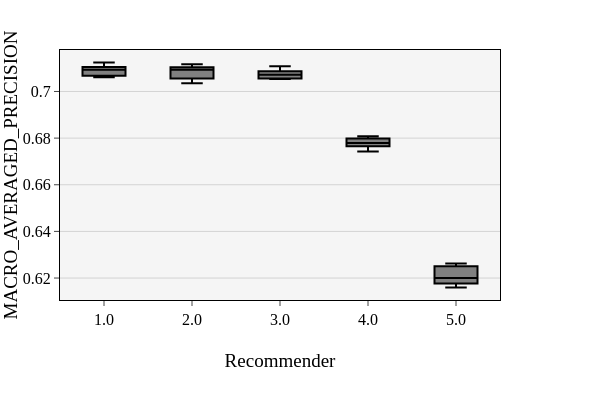

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.708937            0.002240  0.000005  0.706130  0.712429  0.709325  0.706936  0.709863     0.702545     0.714253  0.237497 -1.191498
1         2.0  0.708138            0.002865  0.000008  0.703576  0.711639  0.709296  0.706269  0.709911     0.700805     0.715375 -0.437631 -1.197769
2         3.0  0.707403            0.001965  0.000004  0.705334  0.710806  0.707197  0.705663  0.708017     0.702131     0.711549  0.671503 -0.831450
3         4.0  0.677944            0.002198  0.000005  0.674273  0.680752  0.677953  0.677267  0.679474     0.673956     0.682785 -0.452773 -0.863246
4         5.0  0.621017            0.003884  0.000015  0.615944  0.626198  0.619984  0.618212  0.624747     0.608408     0.634551  0.127166 -1.559202


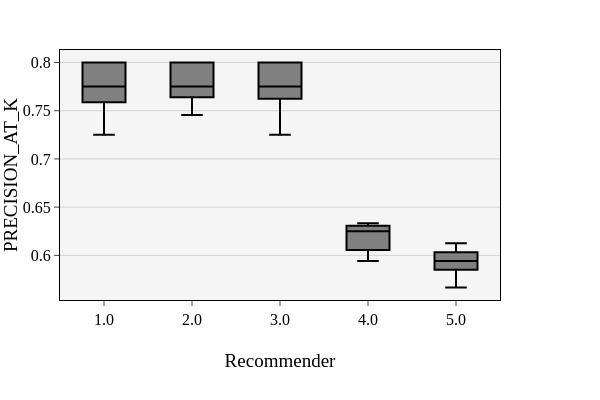

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1    Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.774000            0.027459  0.000754  0.725000  0.800000  0.775000  0.770000  0.80     0.725000     0.845000 -0.797522 -0.650370
1         2.0  0.778091            0.020495  0.000420  0.745455  0.800000  0.775000  0.770000  0.80     0.725000     0.845000 -0.331956 -1.186568
2         3.0  0.775000            0.027386  0.000750  0.725000  0.800000  0.775000  0.775000  0.80     0.737500     0.837500 -0.912871 -0.500000
3         4.0  0.618365            0.014644  0.000214  0.594118  0.633333  0.625000  0.609375  0.63     0.578437     0.660937 -0.621754 -1.161696
4         5.0  0.592892            0.015015  0.000225  0.566667  0.612500  0.594118  0.591176  0.60     0.577941     0.613235 -0.599288 -0.546777


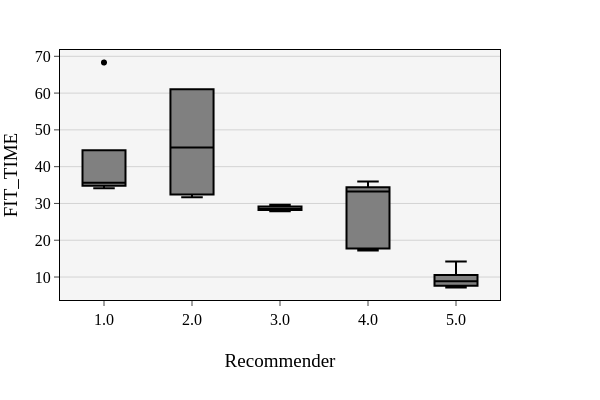

  Recommender       Mean  Standard Deviation    Variance        Min        Max     Median         Q1         Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  41.919042           13.220297  174.776261  34.144460  68.314672  35.622304  35.010350  36.503422    32.770743    38.743029  1.487274  0.233049
1         2.0  46.333602           12.914396  166.781632  31.679895  61.045502  45.176626  32.726815  61.039172    -9.741719   103.507706  0.064720 -1.748914
2         3.0  28.640186            0.626541    0.392554  27.864836  29.648913  28.362422  28.297732  29.027026    27.203792    30.120967  0.452604 -1.132534
3         4.0  27.649962            8.272859   68.440193  17.188053  35.934944  33.229991  17.974040  33.922783    -5.949076    57.845899 -0.375032 -1.805551
4         5.0   9.470362            2.481518    6.157933   7.150654  14.193204   8.850032   7.827502   9.330419     5.573127    11.584795  1.154192 -0.184018


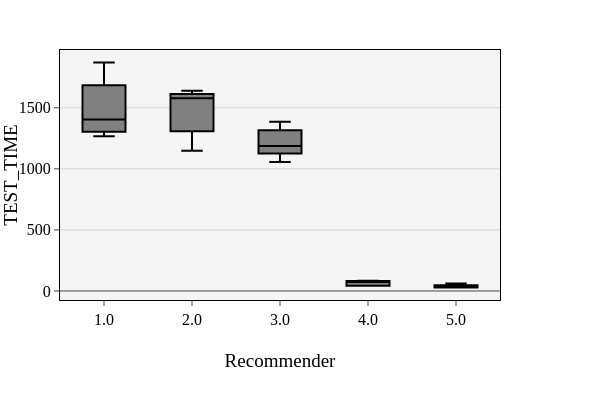

  Recommender         Mean  Standard Deviation      Variance          Min          Max       Median           Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  1495.983729          223.353369  49886.727564  1266.622199  1870.509785  1404.713558  1316.107458  1621.965642   857.320181  2080.752919  0.644171 -1.086440
1         2.0  1465.476887          186.099586  34633.055850  1148.421547  1638.867329  1577.676115  1359.774072  1602.645373   995.467122  1966.952323 -0.739980 -1.058062
2         3.0  1214.076997          114.782887  13175.111176  1055.932903  1385.911968  1186.751621  1148.440404  1293.348087   931.078880  1510.709611  0.173732 -1.207270
3         4.0    65.813828           18.365479    337.290801    42.986402    83.588814    77.666978    43.896043    80.930905   -11.656250   136.483199 -0.377375 -1.814930
4         5.0    37.674449           12.481630    155.791080    28.370619    60.751242    29.253461    28.890233    41.106688    10.565550  

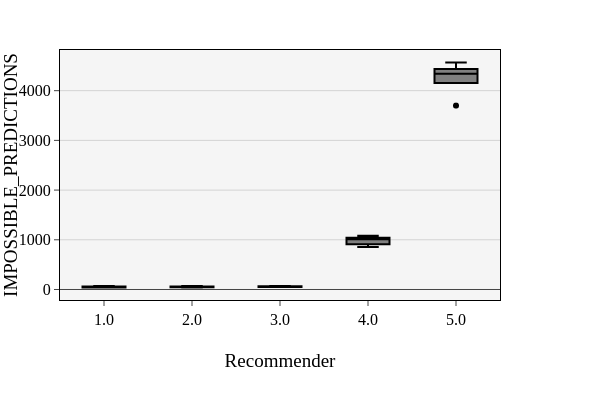

  Recommender    Mean  Standard Deviation  Variance   Min   Max  Median      Q1      Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0    50.6           11.429786    130.64    40    70    45.0    41.0    57.0         17.0         81.0  0.711520 -1.061427
1         2.0    52.6           10.403845    108.24    40    70    51.0    45.0    57.0         27.0         75.0  0.516780 -0.941499
2         3.0    58.2            7.756288     60.16    52    70    52.0    52.0    65.0         32.5         84.5  0.532547 -1.565504
3         4.0   981.2           79.022528   6244.56   856  1082  1012.0   931.0  1025.0        790.0       1166.0 -0.385677 -1.154221
4         5.0  4261.4          294.563134  86767.44  3700  4567  4343.0  4307.0  4390.0       4182.5       4514.5 -1.139591 -0.120942


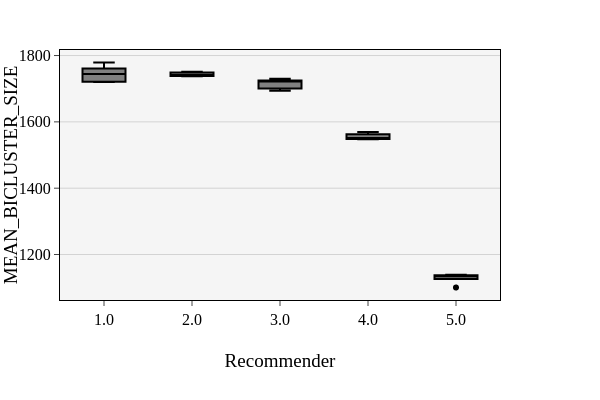

  Recommender         Mean  Standard Deviation    Variance          Min          Max       Median           Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  1743.948566           21.926052  480.751773  1720.085106  1779.021277  1744.478261  1721.723404  1754.434783  1672.656337  1803.501850  0.374316 -1.188396
1         2.0  1743.377980            5.308065   28.175557  1737.909091  1750.844444  1741.477273  1738.250000  1748.409091  1723.011364  1763.647727  0.318684 -1.652757
2         3.0  1714.477949           13.726863  188.426766  1693.600000  1729.974359  1722.538462  1703.200000  1723.076923  1673.384615  1752.892308 -0.437200 -1.459175
3         4.0  1555.266667            8.560815   73.287556  1547.266667  1569.733333  1550.800000  1548.300000  1560.233333  1530.400000  1578.133333  0.704789 -1.091324
4         5.0  1129.830882           14.722044  216.738576  1100.529412  1139.312500  1137.250000  1134.750000  1137.312500  1130.906250  1141.156250 

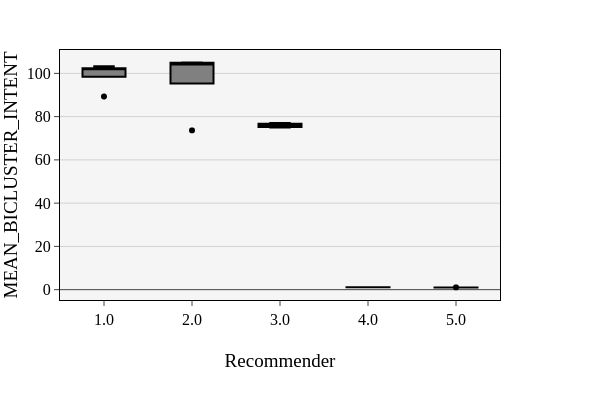

  Recommender       Mean  Standard Deviation    Variance        Min         Max      Median          Q1          Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  99.645143            5.203209   27.073385  89.304348  103.304348  101.957447  101.553191  102.106383   100.723404   102.936170 -1.451776  0.190394
1         2.0  98.034040           12.232111  149.624548  73.636364  105.022727  104.068182  102.511111  104.931818    98.880051   108.562879 -1.480000  0.222292
2         3.0  75.962692            0.766223    0.587098  75.025000   77.051282   75.923077   75.250000   76.564103    73.278846    78.535256  0.142712 -1.510972
3         4.0   1.146667            0.016330    0.000267   1.133333    1.166667    1.133333    1.133333    1.166667     1.083333     1.216667  0.408248 -1.833333
4         5.0   1.011765            0.023529    0.000554   1.000000    1.058824    1.000000    1.000000    1.000000     1.000000     1.000000  1.500000  0.250000


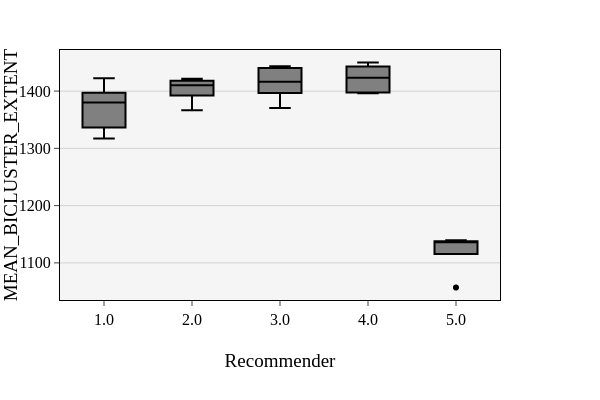

  Recommender         Mean  Standard Deviation     Variance          Min          Max       Median           Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  1370.215634           36.658422  1343.839931  1317.297872  1422.456522  1380.217391  1342.680851  1388.425532  1274.063830  1457.042553 -0.078967 -1.229759
1         2.0  1403.156566           19.590126   383.773051  1366.555556  1421.590909  1410.295455  1400.681818  1416.659091  1376.715909  1440.625000 -1.062948 -0.357480
2         3.0  1415.056154           26.380216   695.915801  1370.375000  1443.230769  1416.461538  1405.675000  1439.538462  1354.879808  1490.333654 -0.577228 -0.942272
3         4.0  1421.746667           21.704158   471.070489  1396.433333  1449.933333  1423.366667  1398.200000  1440.800000  1334.300000  1504.700000  0.000781 -1.665211
4         5.0  1121.125000           32.095147  1030.098438  1057.000000  1139.312500  1137.250000  1134.750000  1137.312500  1130.906250  1141.1

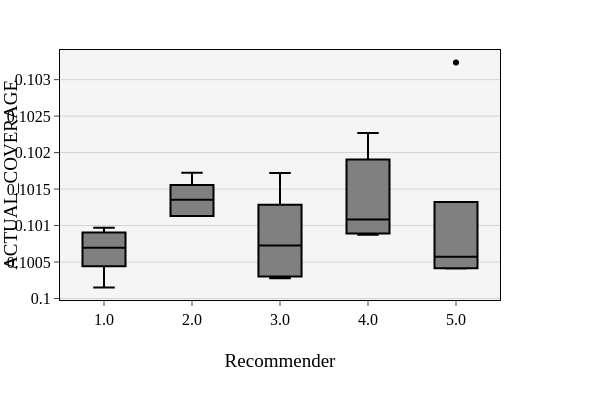

  Recommender      Mean  Standard Deviation      Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.100648            0.000290  8.392187e-08  0.100150  0.100969  0.100696  0.100540  0.100883     0.100027     0.101396 -0.642392 -0.869859
1         2.0  0.101368            0.000227  5.156237e-08  0.101131  0.101725  0.101355  0.101131  0.101501     0.100575     0.102056  0.353851 -1.282081
2         3.0  0.100835            0.000543  2.953445e-07  0.100277  0.101719  0.100727  0.100309  0.101142     0.099059     0.102392  0.499379 -1.177102
3         4.0  0.101381            0.000553  3.060661e-07  0.100875  0.102269  0.101082  0.100897  0.101782     0.099569     0.103110  0.585857 -1.339487
4         5.0  0.101063            0.001091  1.189643e-06  0.100411  0.103235  0.100570  0.100416  0.100683     0.100015     0.101084  1.467786  0.206143


In [4]:
import json
from evaluation.threads import GRECOND_BIAKNN_METIC_NAMES

with open('GreConD_IBPAKNN_sweep_dataset_binarization_threshold.results', 'r') as file_object:
    results = json.load(file_object)

for metric_name in GRECOND_BIAKNN_METIC_NAMES:
    plot.plot_metric_box_plot(metric_name, results)
    print(plot.get_result_table(metric_name, results))

##### user_binarization_threshold

In [ ]:
import json
from evaluation import threads
from recommenders import grecond_recommender
from dataset.movie_lens import load_ml_1m_folds
from dataset.movie_lens import resolve_folds

data, k_fold = load_ml_1m_folds()

best_params_user = {
    'grecond_coverage': 0.1,
    'dataset_binarization_threshold': 3.0,
    'minimum_bicluster_sparsity': None,
    'minimum_bicluster_coverage': None,
    'minimum_bicluster_relative_size': None,
    'user_binarization_threshold': 3.0,
    'number_of_top_k_biclusters': None,
    'knn_k': 100,
    'knn_type': 'item'
 }

folds = resolve_folds(data, k_fold)

user_binarization_thresholds = [1.0, 2.0, 3.0, 4.0, 5.0]

recommender_variations = [
    threads.RecommenderVariation(
        str(user_binarization_threshold),
        grecond_recommender.GreConDBiAKNNRecommender(
            grecond_coverage=best_params_user['grecond_coverage'],
            dataset_binarization_threshold=best_params_user['dataset_binarization_threshold'],
            minimum_bicluster_sparsity=best_params_user["minimum_bicluster_sparsity"],
            minimum_bicluster_coverage=best_params_user["minimum_bicluster_coverage"],
            minimum_bicluster_relative_size=best_params_user["minimum_bicluster_relative_size"],
            knn_type=best_params_user["knn_type"],
            user_binarization_threshold=user_binarization_threshold,
            number_of_top_k_biclusters=best_params_user["number_of_top_k_biclusters"],
            knn_k=best_params_user["knn_k"],
        ),
    )
    for user_binarization_threshold in user_binarization_thresholds
]

from evaluation.threads import grecond_biaknn_benchmark_thread

results = plot.benchmark(
    folds,
    recommender_variations,
    [],
    repeats=REPEAT,
    relevance_threshold=RELEVANCE_THRESHOLD,
    number_of_top_recommendations=NUMBER_OF_TOP_RECOMMENDATIONS,
    benchmark_thread=grecond_biaknn_benchmark_thread,
    thread_count=8
)

with open('GreConD_IBPAKNN_sweep_user_binarization_threshold.results', 'w') as file_object:
    json.dump(results, file_object, indent=4)

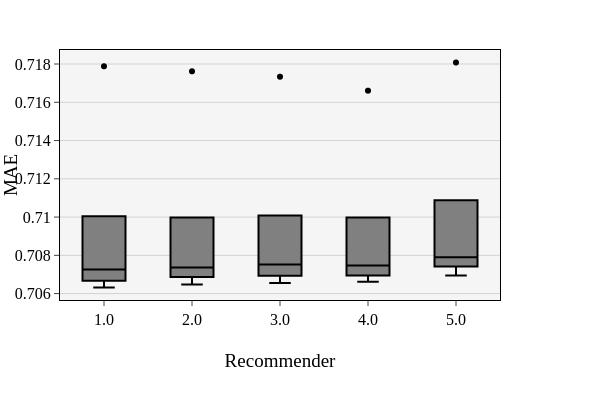

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.709134            0.004391  0.000019  0.706319  0.717883  0.707254  0.706787  0.707426     0.705829     0.708384  1.470879  0.212170
1         2.0  0.709178            0.004235  0.000018  0.706479  0.717620  0.707367  0.706998  0.707425     0.706356     0.708067  1.475911  0.219120
2         3.0  0.709227            0.004073  0.000017  0.706556  0.717335  0.707523  0.707052  0.707667     0.706130     0.708590  1.465384  0.205329
3         4.0  0.709102            0.003772  0.000014  0.706618  0.716606  0.707468  0.707050  0.707766     0.705976     0.708841  1.460321  0.198030
4         5.0  0.709798            0.004170  0.000017  0.706947  0.718079  0.707904  0.707580  0.708477     0.706234     0.709824  1.447335  0.180690


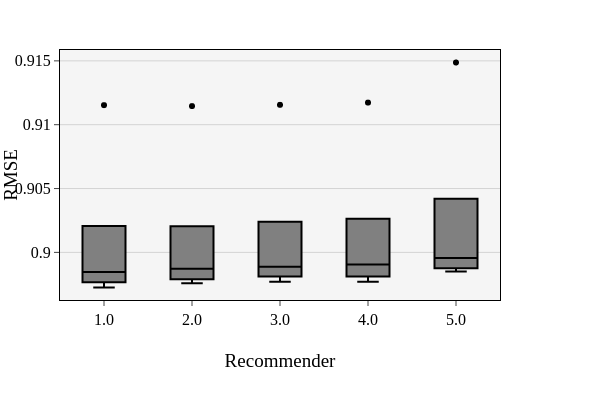

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.900794            0.005398  0.000029  0.897250  0.911531  0.898470  0.897806  0.898911     0.896148     0.900570  1.458765  0.195672
1         2.0  0.900935            0.005283  0.000028  0.897582  0.911457  0.898721  0.897994  0.898922     0.896603     0.900313  1.468470  0.208528
2         3.0  0.901145            0.005235  0.000027  0.897692  0.911556  0.898866  0.898263  0.899346     0.896638     0.900971  1.457598  0.194091
3         4.0  0.901269            0.005273  0.000028  0.897695  0.911732  0.899047  0.898255  0.899614     0.896215     0.901654  1.442168  0.173304
4         5.0  0.902484            0.006237  0.000039  0.898494  0.914871  0.899558  0.898853  0.900645     0.896164     0.903335  1.449193  0.179596


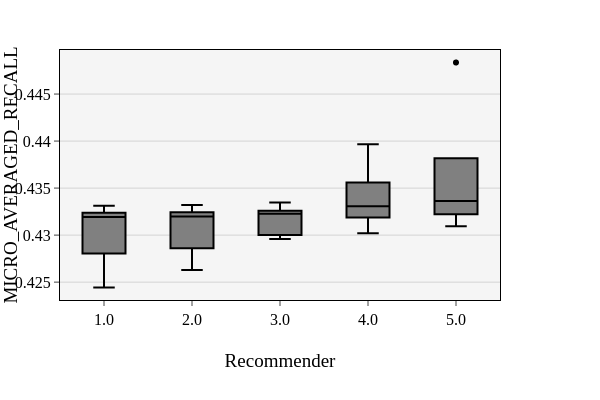

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.430178            0.003145  0.000010  0.424429  0.433117  0.431932  0.429265  0.432147     0.424943     0.436469 -0.978988 -0.564760
1         2.0  0.430609            0.002504  0.000006  0.426290  0.433212  0.431992  0.429370  0.432182     0.425152     0.436399 -0.742690 -0.934580
2         3.0  0.431555            0.001446  0.000002  0.429596  0.433455  0.432260  0.430159  0.432305     0.426939     0.435524 -0.172258 -1.530978
3         4.0  0.433921            0.003153  0.000010  0.430205  0.439652  0.433077  0.432425  0.434245     0.429695     0.436975  0.848809 -0.419838
4         5.0  0.436073            0.006269  0.000039  0.430936  0.448355  0.433624  0.432660  0.434792     0.429462     0.437990  1.347635  0.058293


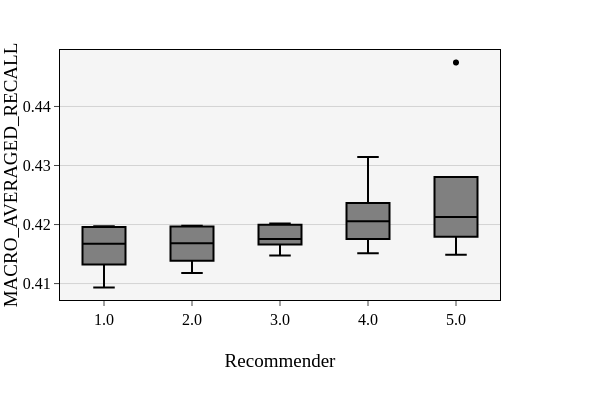

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.415966            0.003829  0.000015  0.409339  0.419710  0.416752  0.414510  0.419519     0.406997     0.427032 -0.699626 -0.869088
1         2.0  0.416529            0.003046  0.000009  0.411804  0.419793  0.416851  0.414584  0.419613     0.407041     0.427156 -0.344925 -1.333788
2         3.0  0.417930            0.001980  0.000004  0.414770  0.420189  0.417536  0.417250  0.419906     0.413266     0.423891 -0.327022 -1.163640
3         4.0  0.421312            0.005486  0.000030  0.415133  0.431456  0.420540  0.418355  0.421075     0.414274     0.425156  0.946969 -0.322872
4         5.0  0.424829            0.011561  0.000134  0.414877  0.447447  0.421269  0.418943  0.421608     0.414947     0.425604  1.333472  0.056103


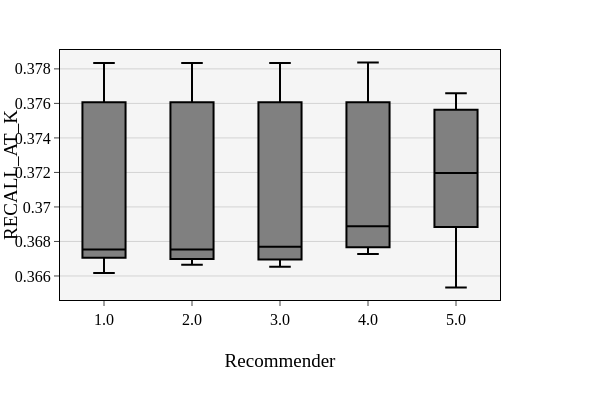

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.370939            0.004921  0.000024  0.366171  0.378341  0.367535  0.367346  0.375305     0.355409     0.387242  0.493987 -1.573599
1         2.0  0.370987            0.004868  0.000024  0.366656  0.378341  0.367535  0.367101  0.375305     0.354796     0.387610  0.514755 -1.577988
2         3.0  0.370992            0.004870  0.000024  0.366528  0.378341  0.367687  0.367101  0.375305     0.354796     0.387610  0.507331 -1.575207
3         4.0  0.371522            0.004477  0.000020  0.367273  0.378370  0.368875  0.367786  0.375305     0.356509     0.386582  0.508028 -1.519518
4         5.0  0.371840            0.004006  0.000016  0.365332  0.376588  0.371961  0.370016  0.375305     0.362083     0.383238 -0.414247 -1.091760


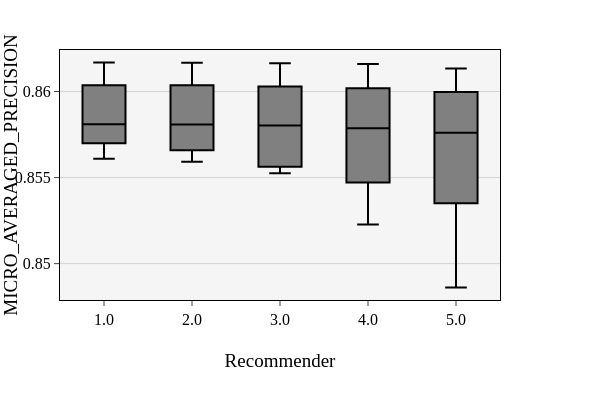

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.858613            0.001977  0.000004  0.856087  0.861685  0.858091  0.857288  0.859915     0.853348     0.863855  0.325907 -1.221813
1         2.0  0.858482            0.002086  0.000004  0.855923  0.861665  0.858089  0.856803  0.859932     0.852111     0.864625  0.302440 -1.332011
2         3.0  0.858102            0.002416  0.000006  0.855254  0.861641  0.858024  0.855751  0.859841     0.849616     0.865976  0.191012 -1.460747
3         4.0  0.857394            0.003257  0.000011  0.852268  0.861597  0.857863  0.855526  0.859715     0.849242     0.865999 -0.314471 -1.144876
4         5.0  0.856442            0.004420  0.000020  0.848614  0.861334  0.857605  0.855144  0.859512     0.848593     0.866064 -0.774277 -0.682874


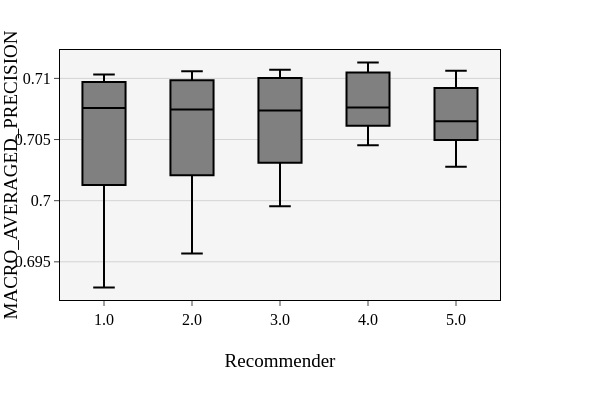

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.704879            0.006362  0.000040  0.692902  0.710324  0.707583  0.704089  0.709498     0.695975     0.717613 -1.117645 -0.318111
1         2.0  0.705511            0.005375  0.000029  0.695690  0.710592  0.707447  0.704219  0.709608     0.696135     0.717692 -0.955912 -0.540045
2         3.0  0.706346            0.004065  0.000017  0.699540  0.710715  0.707375  0.704296  0.709804     0.696035     0.718065 -0.589692 -1.043222
3         4.0  0.708062            0.002439  0.000006  0.704534  0.711299  0.707623  0.706646  0.710210     0.701299     0.715557 -0.041864 -1.359905
4         5.0  0.706860            0.002681  0.000007  0.702769  0.710623  0.706486  0.705686  0.708735     0.701113     0.713309 -0.106562 -1.083210


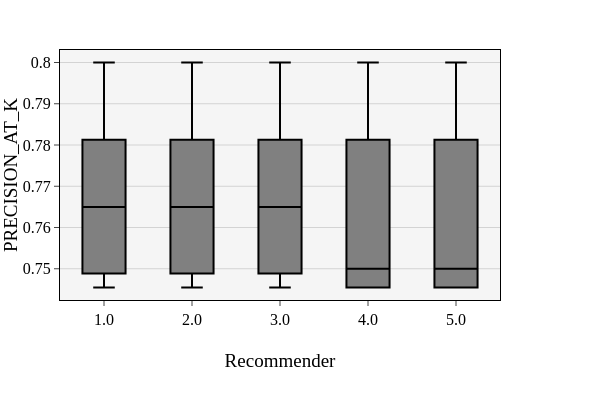

  Recommender      Mean  Standard Deviation  Variance       Min  Max  Median        Q1     Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.767091            0.019546  0.000382  0.745455  0.8   0.765  0.750000  0.775     0.712500     0.812500  0.562615 -0.970105
1         2.0  0.767091            0.019546  0.000382  0.745455  0.8   0.765  0.750000  0.775     0.712500     0.812500  0.562615 -0.970105
2         3.0  0.767091            0.019546  0.000382  0.745455  0.8   0.765  0.750000  0.775     0.712500     0.812500  0.562615 -0.970105
3         4.0  0.763182            0.021436  0.000460  0.745455  0.8   0.750  0.745455  0.775     0.701136     0.819318  0.774182 -1.025228
4         5.0  0.763182            0.021436  0.000460  0.745455  0.8   0.750  0.745455  0.775     0.701136     0.819318  0.774182 -1.025228


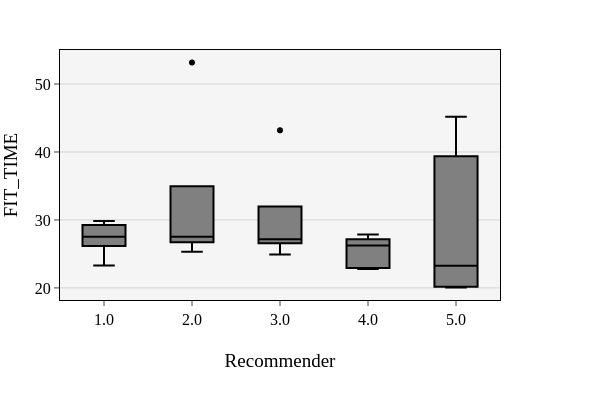

  Recommender       Mean  Standard Deviation    Variance        Min        Max     Median         Q1         Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  27.366470            2.261066    5.112421  23.302872  29.843146  27.526572  27.112457  29.047304    24.210186    31.949574 -0.816181 -0.564473
1         2.0  32.416042           10.436794  108.926671  25.304401  53.163451  27.524921  27.193589  28.893847    24.643202    31.444235  1.454553  0.191220
2         3.0  30.128476            6.622389   43.856041  24.914639  43.194297  27.160398  27.118772  28.254274    25.415519    29.957527  1.397102  0.125253
3         4.0  25.360828            2.091975    4.376359  22.794072  27.870507  26.234540  22.965270  26.939752    17.003548    32.901474 -0.223858 -1.717597
4         5.0  29.220488           10.228824  104.628840  20.060021  45.189400  23.258232  20.185850  37.408938    -5.648783    63.243571  0.542523 -1.456375


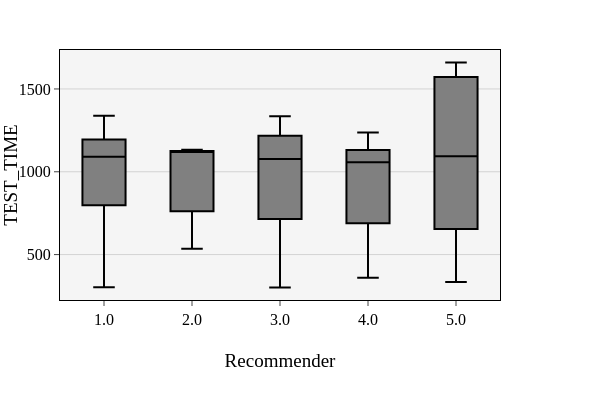

  Recommender         Mean  Standard Deviation       Variance         Min          Max       Median          Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0   968.390412          353.888874  125237.334991  303.287183  1338.049099  1091.079133  962.026705  1147.509941   683.801851  1425.734795 -1.065477 -0.250605
1         2.0   950.025198          235.648286   55530.114481  534.762659  1132.968663  1120.385473  838.180905  1123.828291   409.709826  1552.299371 -0.866464 -0.874688
2         3.0   948.985617          359.711178  129392.131904  301.297755  1334.762996  1077.263976  852.625703  1178.977653   363.097779  1668.505577 -0.863315 -0.595513
3         4.0   910.182796          309.314494   95675.456389  360.119573  1236.881496  1057.957804  799.012200  1096.942905   352.116142  1543.838963 -0.832580 -0.710539
4         5.0  1078.192634          491.368002  241442.513121  334.987704  1659.745649  1093.181087  760.579773  1542.468958  -412.254005  2715.3

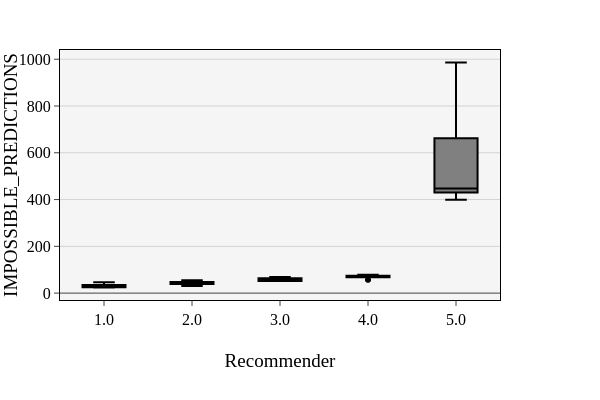

  Recommender   Mean  Standard Deviation  Variance  Min  Max  Median     Q1     Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0   31.4            7.735632     59.84   24   46    30.0   26.0   31.0         18.5         38.5  1.100298 -0.247003
1         2.0   43.2            7.984986     63.76   30   55    44.0   42.0   45.0         37.5         49.5 -0.256253 -0.551970
2         3.0   57.6            6.829348     46.64   52   69    53.0   52.0   62.0         37.0         77.0  0.702095 -1.190673
3         4.0   70.6            7.282857     53.04   57   79    72.0   72.0   73.0         70.5         74.5 -0.985517 -0.211062
4         5.0  565.2          216.548747  46893.36  399  986   447.0  440.0  554.0        269.0        725.0  1.305918 -0.038761


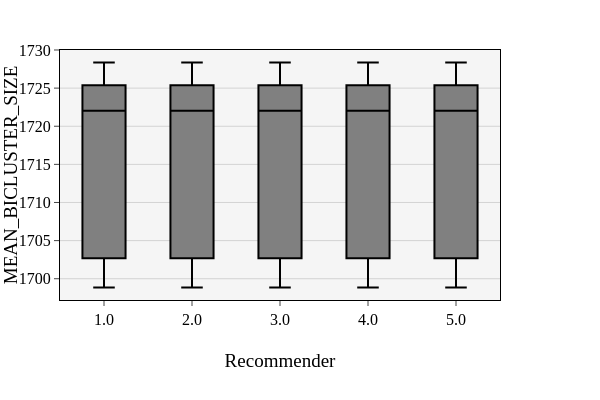

  Recommender         Mean  Standard Deviation    Variance      Min          Max       Median       Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  1715.508718           11.807144  139.408652  1698.85  1728.358974  1722.025641  1703.95  1724.358974  1673.336538  1754.972436 -0.373672 -1.661472
1         2.0  1715.508718           11.807144  139.408652  1698.85  1728.358974  1722.025641  1703.95  1724.358974  1673.336538  1754.972436 -0.373672 -1.661472
2         3.0  1715.508718           11.807144  139.408652  1698.85  1728.358974  1722.025641  1703.95  1724.358974  1673.336538  1754.972436 -0.373672 -1.661472
3         4.0  1715.508718           11.807144  139.408652  1698.85  1728.358974  1722.025641  1703.95  1724.358974  1673.336538  1754.972436 -0.373672 -1.661472
4         5.0  1715.508718           11.807144  139.408652  1698.85  1728.358974  1722.025641  1703.95  1724.358974  1673.336538  1754.972436 -0.373672 -1.661472


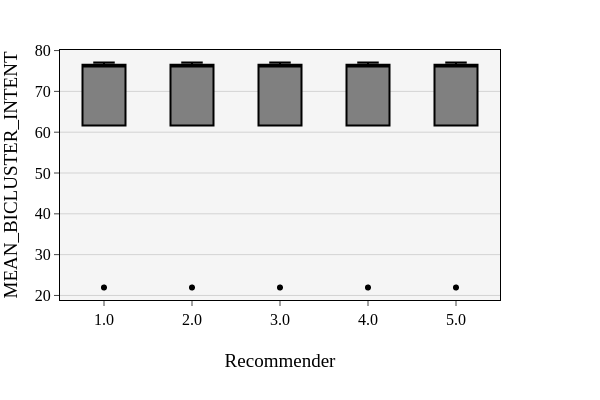

  Recommender       Mean  Standard Deviation  Variance    Min        Max     Median      Q1         Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  65.262436           21.667803  469.4937  21.95  77.076923  76.076923  74.875  76.333333      72.6875    78.520833 -1.496009  0.244627
1         2.0  65.262436           21.667803  469.4937  21.95  77.076923  76.076923  74.875  76.333333      72.6875    78.520833 -1.496009  0.244627
2         3.0  65.262436           21.667803  469.4937  21.95  77.076923  76.076923  74.875  76.333333      72.6875    78.520833 -1.496009  0.244627
3         4.0  65.262436           21.667803  469.4937  21.95  77.076923  76.076923  74.875  76.333333      72.6875    78.520833 -1.496009  0.244627
4         5.0  65.262436           21.667803  469.4937  21.95  77.076923  76.076923  74.875  76.333333      72.6875    78.520833 -1.496009  0.244627


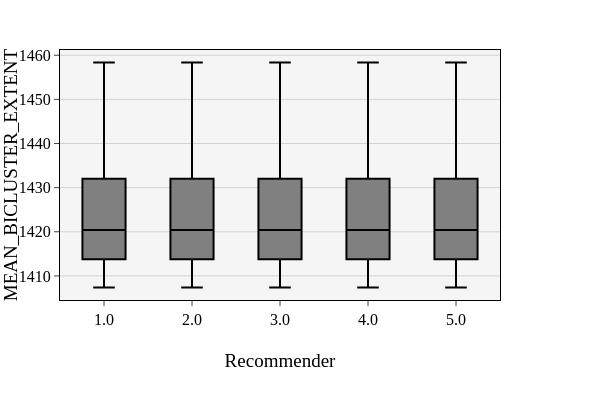

  Recommender         Mean  Standard Deviation    Variance       Min          Max    Median           Q1          Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  1425.062564           17.494397  306.053925  1407.375  1458.358974  1420.425  1415.897436  1423.25641  1404.858974  1434.294872  1.139475 -0.150581
1         2.0  1425.062564           17.494397  306.053925  1407.375  1458.358974  1420.425  1415.897436  1423.25641  1404.858974  1434.294872  1.139475 -0.150581
2         3.0  1425.062564           17.494397  306.053925  1407.375  1458.358974  1420.425  1415.897436  1423.25641  1404.858974  1434.294872  1.139475 -0.150581
3         4.0  1425.062564           17.494397  306.053925  1407.375  1458.358974  1420.425  1415.897436  1423.25641  1404.858974  1434.294872  1.139475 -0.150581
4         5.0  1425.062564           17.494397  306.053925  1407.375  1458.358974  1420.425  1415.897436  1423.25641  1404.858974  1434.294872  1.139475 -0.150581


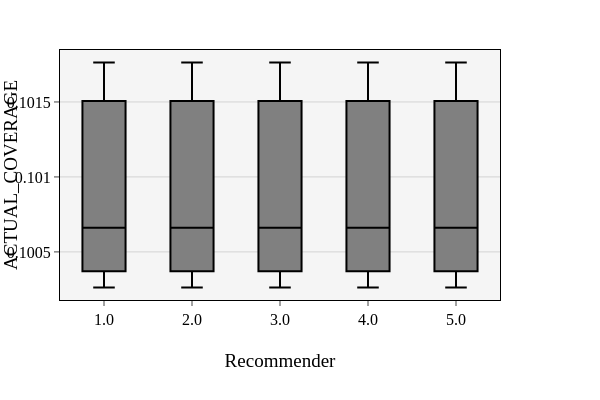

  Recommender      Mean  Standard Deviation      Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0         1.0  0.100903            0.000587  3.443593e-07  0.100263  0.101763  0.100662  0.100407  0.101421     0.098888      0.10294  0.372336 -1.564632
1         2.0  0.100903            0.000587  3.443593e-07  0.100263  0.101763  0.100662  0.100407  0.101421     0.098888      0.10294  0.372336 -1.564632
2         3.0  0.100903            0.000587  3.443593e-07  0.100263  0.101763  0.100662  0.100407  0.101421     0.098888      0.10294  0.372336 -1.564632
3         4.0  0.100903            0.000587  3.443593e-07  0.100263  0.101763  0.100662  0.100407  0.101421     0.098888      0.10294  0.372336 -1.564632
4         5.0  0.100903            0.000587  3.443593e-07  0.100263  0.101763  0.100662  0.100407  0.101421     0.098888      0.10294  0.372336 -1.564632


In [5]:
import json
from evaluation.threads import GRECOND_BIAKNN_METIC_NAMES

with open('GreConD_IBPAKNN_sweep_user_binarization_threshold.results', 'r') as file_object:
    results = json.load(file_object)

for metric_name in GRECOND_BIAKNN_METIC_NAMES:
    plot.plot_metric_box_plot(metric_name, results)
    print(plot.get_result_table(metric_name, results))

##### knn_k

In [ ]:
import json
from evaluation import threads
from recommenders import grecond_recommender
from dataset.movie_lens import load_ml_1m_folds
from dataset.movie_lens import resolve_folds

data, k_fold = load_ml_1m_folds()

best_params_user = {
    'grecond_coverage': 0.1,
    'dataset_binarization_threshold': 3.0,
    'minimum_bicluster_sparsity': None,
    'minimum_bicluster_coverage': None,
    'minimum_bicluster_relative_size': None,
    'user_binarization_threshold': 3.0,
    'number_of_top_k_biclusters': None,
    'knn_k': 100,
    'knn_type': 'item'
 }

folds = resolve_folds(data, k_fold)

knn_ks = [1, 20, 50, 100, 200, 500, 1000]

recommender_variations = [
    threads.RecommenderVariation(
        str(knn_k),
        grecond_recommender.GreConDBiAKNNRecommender(
            grecond_coverage=best_params_user['grecond_coverage'],
            dataset_binarization_threshold=best_params_user['dataset_binarization_threshold'],
            minimum_bicluster_sparsity=best_params_user["minimum_bicluster_sparsity"],
            minimum_bicluster_coverage=best_params_user["minimum_bicluster_coverage"],
            minimum_bicluster_relative_size=best_params_user["minimum_bicluster_relative_size"],
            knn_type=best_params_user["knn_type"],
            user_binarization_threshold=best_params_user["user_binarization_threshold"],
            number_of_top_k_biclusters=best_params_user["number_of_top_k_biclusters"],
            knn_k=knn_k,
        ),
    )
    for knn_k in knn_ks
]

from evaluation.threads import grecond_biaknn_benchmark_thread

results = plot.benchmark(
    folds,
    recommender_variations,
    [],
    repeats=REPEAT,
    relevance_threshold=RELEVANCE_THRESHOLD,
    number_of_top_recommendations=NUMBER_OF_TOP_RECOMMENDATIONS,
    benchmark_thread=grecond_biaknn_benchmark_thread,
    thread_count=8
)

with open('GreConD_IBPAKNN_sweep_knn_k.results', 'w') as file_object:
    json.dump(results, file_object, indent=4)

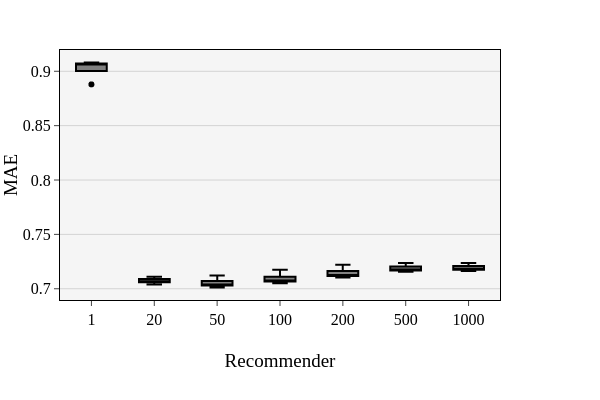

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  0.902743            0.007495  0.000056  0.887944  0.908074  0.906600  0.904369  0.906729     0.900829     0.910270 -1.408639  0.122636
1          20  0.707271            0.002372  0.000006  0.703842  0.711108  0.706678  0.706564  0.708162     0.704168     0.710558  0.244885 -0.749567
2          50  0.705214            0.003714  0.000014  0.701152  0.712111  0.703743  0.703583  0.705479     0.700740     0.708323  0.990236 -0.322097
3         100  0.709129            0.004335  0.000019  0.704975  0.717445  0.707206  0.707195  0.708826     0.704747     0.711274  1.200674 -0.106534
4         200  0.714278            0.004130  0.000017  0.710367  0.722149  0.712289  0.712262  0.714322     0.709172     0.717411  1.169453 -0.177411
5         500  0.718633            0.002764  0.000008  0.715622  0.723600  0.717411  0.717103  0.719

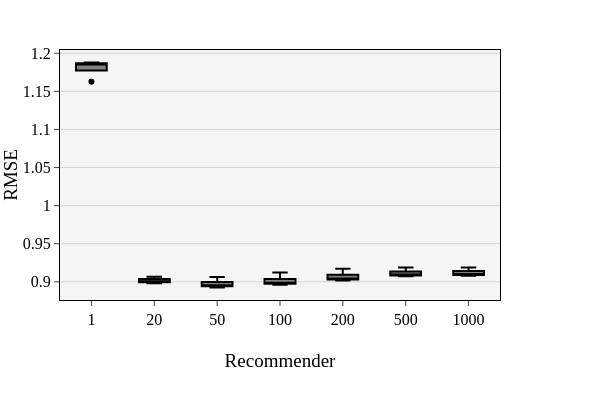

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  1.180926            0.009291  0.000086  1.162722  1.187868  1.185282  1.182231  1.186527     1.175788     1.192970 -1.355885  0.045805
1          20  0.901626            0.002901  0.000008  0.898050  0.906575  0.900720  0.900000  0.902785     0.895822     0.906963  0.589432 -0.818598
2          50  0.897255            0.004835  0.000023  0.892572  0.906429  0.895194  0.894701  0.897377     0.890687     0.901391  1.139829 -0.208834
3         100  0.901191            0.005730  0.000033  0.896138  0.912257  0.898704  0.898056  0.900799     0.893942     0.904913  1.254501 -0.071410
4         200  0.906655            0.005470  0.000030  0.901863  0.917177  0.904174  0.903533  0.906526     0.899044     0.911016  1.233492 -0.113559
5         500  0.911259            0.003985  0.000016  0.907478  0.918669  0.909684  0.908556  0.911

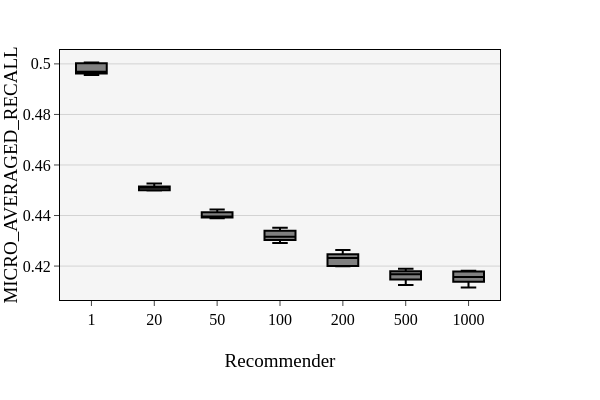

  Recommender      Mean  Standard Deviation      Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  0.497919            0.002048  4.194533e-06  0.495589  0.500551  0.496850  0.496406  0.500196     0.490722     0.505881  0.296556 -1.739150
1          20  0.450935            0.000976  9.523318e-07  0.449908  0.452630  0.451010  0.450038  0.451088     0.448462     0.452665  0.660170 -0.791799
2          50  0.440201            0.001306  1.704822e-06  0.438969  0.442431  0.439383  0.439290  0.440933     0.436825     0.443398  0.745659 -1.043152
3         100  0.432043            0.002123  4.508048e-06  0.429121  0.435147  0.431587  0.430745  0.433616     0.426439     0.437922  0.137268 -1.280296
4         200  0.422735            0.002473  6.117865e-06  0.419906  0.426385  0.423155  0.420075  0.424155     0.413956     0.430274  0.133410 -1.420287
5         500  0.416254            0.002189  4.790766e-06  0.412528  0.41890

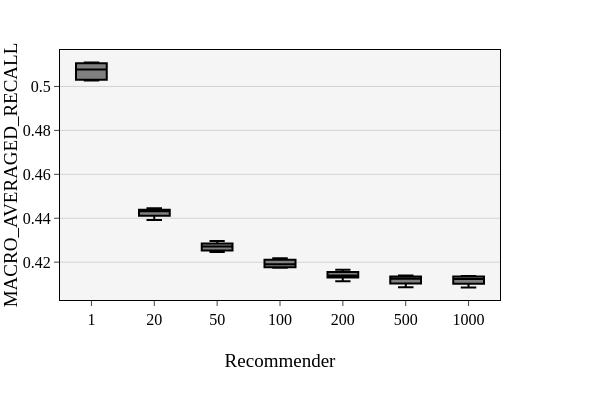

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  0.506993            0.003490  0.000012  0.502697  0.510912  0.507690  0.503189  0.510478     0.492256     0.521411 -0.148177 -1.741926
1          20  0.442460            0.001856  0.000003  0.439217  0.444522  0.443132  0.441748  0.443682     0.438847     0.446582 -0.737782 -0.784693
2          50  0.426993            0.001806  0.000003  0.424603  0.429661  0.427078  0.425508  0.428116     0.421595     0.432029  0.118072 -1.311936
3         100  0.419356            0.001696  0.000003  0.417433  0.421742  0.418988  0.417750  0.420866     0.413076     0.425539  0.235099 -1.599573
4         200  0.414117            0.001749  0.000003  0.411331  0.416568  0.413866  0.413607  0.415216     0.411192     0.417630 -0.214471 -0.909721
5         500  0.411841            0.001901  0.000004  0.408624  0.413888  0.412462  0.410892  0.413

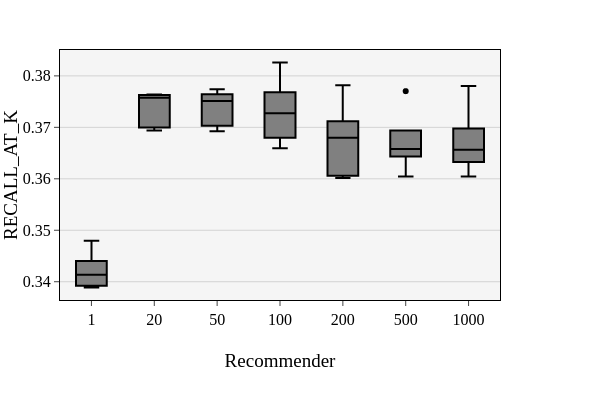

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  0.342046            0.003258  0.000011  0.338878  0.347943  0.341360  0.339336  0.342713     0.334270     0.347778  0.886820 -0.577930
1          20  0.373587            0.003123  0.000010  0.369378  0.376360  0.375768  0.370186  0.376241     0.361103     0.385324 -0.416539 -1.783233
2          50  0.373703            0.003181  0.000010  0.369239  0.377397  0.375096  0.370662  0.376120     0.362474     0.384308 -0.309379 -1.620152
3         100  0.372964            0.005736  0.000033  0.365921  0.382600  0.372743  0.368682  0.374874     0.359394     0.384162  0.502178 -0.887440
4         200  0.367173            0.006573  0.000043  0.360156  0.378203  0.367960  0.360711  0.368834     0.348527     0.381018  0.515279 -0.966871
5         500  0.367146            0.005415  0.000029  0.360463  0.377028  0.365776  0.365626  0.366

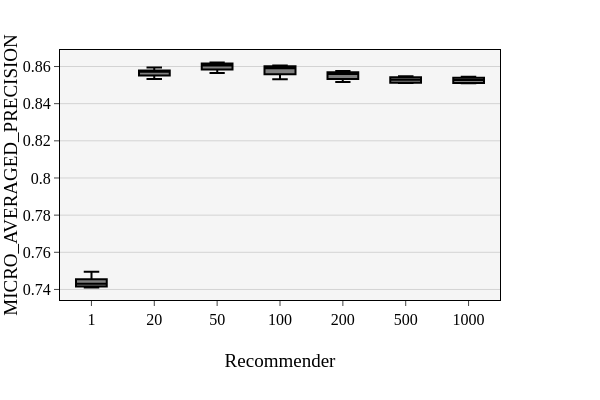

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  0.743920            0.002985  0.000009  0.741045  0.749500  0.743113  0.741812  0.744132     0.738332     0.747612  1.053314 -0.334362
1          20  0.856577            0.002051  0.000004  0.853265  0.859507  0.857150  0.855729  0.857235     0.853469     0.859494 -0.262110 -0.798272
2          50  0.859955            0.001999  0.000004  0.856574  0.862163  0.860548  0.858988  0.861502     0.855217     0.865273 -0.622613 -0.982610
3         100  0.857908            0.002698  0.000007  0.853202  0.860583  0.859044  0.856712  0.859998     0.851782     0.864927 -0.775888 -0.869208
4         200  0.855152            0.002138  0.000005  0.851621  0.857610  0.856007  0.853921  0.856601     0.849901     0.860621 -0.560028 -1.093503
5         500  0.852820            0.001432  0.000002  0.851118  0.854799  0.852870  0.851355  0.853

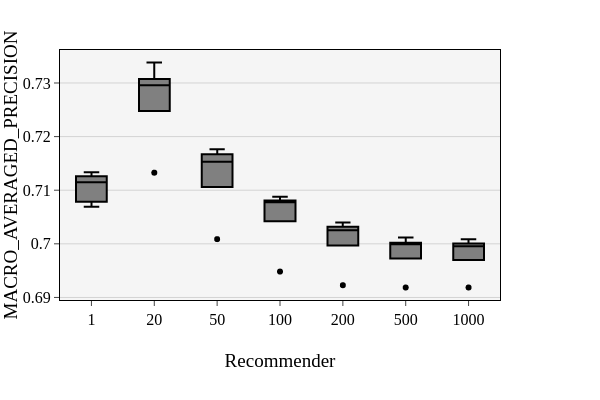

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  0.710457            0.002484  0.000006  0.706930  0.713357  0.711479  0.708153  0.712366     0.701835     0.718684 -0.309334 -1.591569
1          20  0.726986            0.007093  0.000050  0.713264  0.733821  0.729558  0.728589  0.729698     0.726925     0.731361 -1.246111 -0.017807
2          50  0.712811            0.006097  0.000037  0.700875  0.717649  0.715296  0.713855  0.716381     0.710067     0.720168 -1.345908  0.045813
3         100  0.705312            0.005263  0.000028  0.694827  0.708780  0.707761  0.707347  0.707844     0.706601     0.708590 -1.469779  0.211698
4         200  0.700767            0.004287  0.000018  0.692282  0.703985  0.702513  0.702150  0.702905     0.701017     0.704038 -1.421245  0.153304
5         500  0.698375            0.003331  0.000011  0.691853  0.701171  0.699902  0.699047  0.699

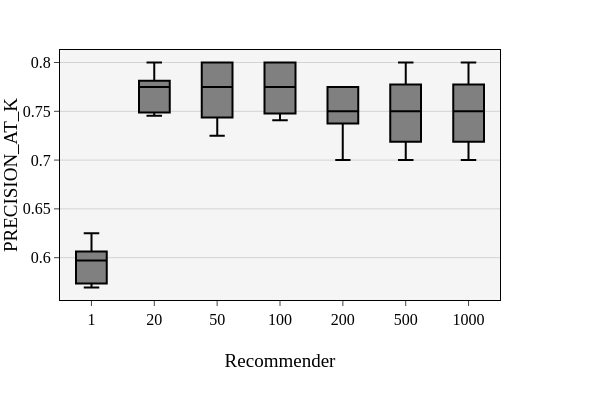

  Recommender      Mean  Standard Deviation  Variance       Min    Max    Median     Q1     Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  0.593301            0.019839  0.000394  0.569444  0.625  0.597059  0.575  0.600       0.5375       0.6375  0.320197 -1.130446
1          20  0.769091            0.019740  0.000390  0.745455  0.800  0.775000  0.750  0.775       0.7125       0.8125  0.254269 -1.208499
2          50  0.770000            0.029155  0.000850  0.725000  0.800  0.775000  0.750  0.800       0.6750       0.8750 -0.363173 -1.371972
3         100  0.773182            0.024579  0.000604  0.740909  0.800  0.775000  0.750  0.800       0.6750       0.8750 -0.100865 -1.680390
4         200  0.750000            0.027386  0.000750  0.700000  0.775  0.750000  0.750  0.775       0.7125       0.8125 -0.912871 -0.500000
5         500  0.749000            0.034699  0.001204  0.700000  0.800  0.750000  0.725  0.770       0.6575       0.8375  0.049979 -1.198660
6        1000

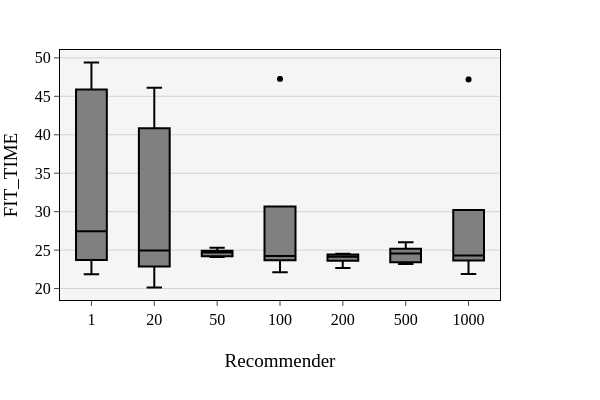

  Recommender       Mean  Standard Deviation    Variance        Min        Max     Median         Q1         Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  33.552876           11.263051  126.856328  21.873684  49.396961  27.447581  24.332741  44.713412    -6.238265    75.284418  0.386773 -1.685659
1          20  30.816259           10.007940  100.158858  20.137264  46.117738  24.951063  23.774542  39.100690     0.785320    62.089912  0.475349 -1.481287
2          50  24.622065            0.422655    0.178637  24.109450  25.293468  24.702941  24.233561  24.770903    23.427548    25.576916  0.299709 -1.147547
3         100  28.592823            9.388542   88.144725  22.111631  47.263822  24.227745  24.209022  25.151897    22.794710    26.566210  1.456931  0.196176
4         200  23.937244            0.657635    0.432483  22.687070  24.529812  24.148313  23.932371  24.388654    23.247946    25.073079 -1.156391 -0.209641
5         500  24.436863            1.013578    1.02

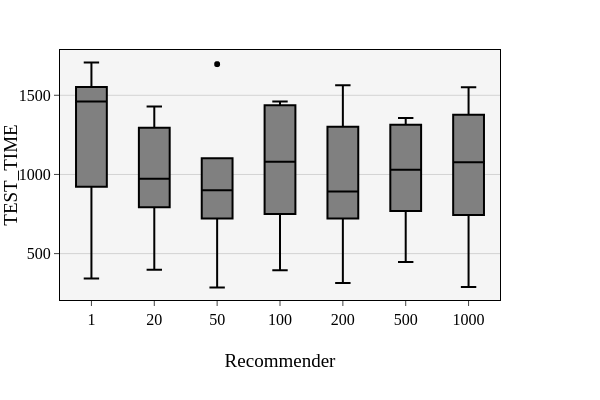

  Recommender         Mean  Standard Deviation       Variance         Min          Max       Median           Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  1225.183199          480.225622  230616.648498  343.378010  1707.067760  1461.122607  1114.589027  1499.758588   536.834685  2077.512930 -0.977521 -0.489900
1          20   994.515127          350.815768  123071.703012  397.793566  1428.461876   972.288233   923.667789  1250.364170   433.623219  1740.408740 -0.529843 -0.800682
2          50   930.576192          449.015596  201615.005186  285.954928  1696.590380   900.431366   866.392817   903.511468   810.714842   959.189443  0.400548 -0.456262
3         100  1047.195674          393.707746  155005.788988  395.527795  1461.123941  1080.768497   869.054037  1429.504100    28.378942  2270.179195 -0.509810 -1.068217
4         200   967.884020          414.963077  172194.355168  313.937420  1563.880807   891.581802   857.134210  1212.885861   323.506734  

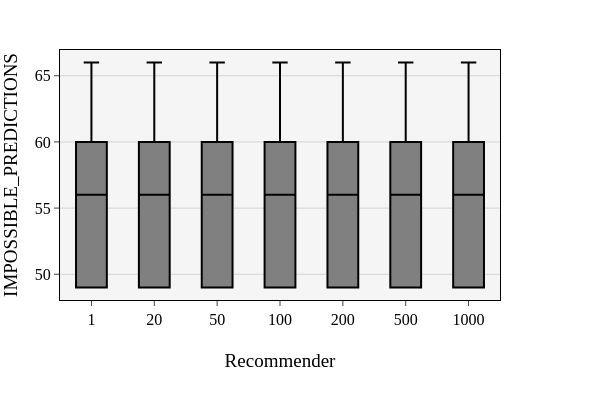

  Recommender  Mean  Standard Deviation  Variance  Min  Max  Median    Q1    Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  55.6            6.343501     40.24   49   66    56.0  49.0  58.0         35.5         71.5   0.44171  -1.08224
1          20  55.6            6.343501     40.24   49   66    56.0  49.0  58.0         35.5         71.5   0.44171  -1.08224
2          50  55.6            6.343501     40.24   49   66    56.0  49.0  58.0         35.5         71.5   0.44171  -1.08224
3         100  55.6            6.343501     40.24   49   66    56.0  49.0  58.0         35.5         71.5   0.44171  -1.08224
4         200  55.6            6.343501     40.24   49   66    56.0  49.0  58.0         35.5         71.5   0.44171  -1.08224
5         500  55.6            6.343501     40.24   49   66    56.0  49.0  58.0         35.5         71.5   0.44171  -1.08224
6        1000  55.6            6.343501     40.24   49   66    56.0  49.0  58.0         35.5         71.5   0.44171  -

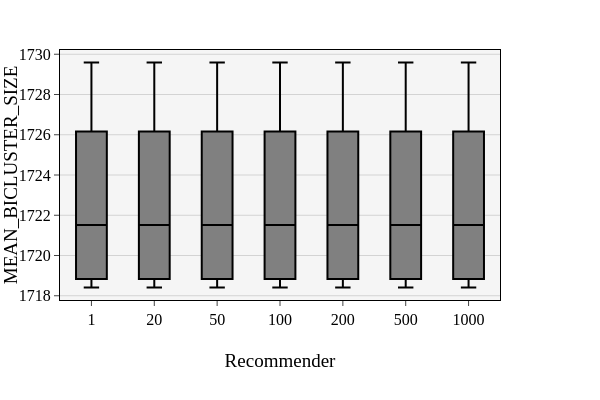

  Recommender         Mean  Standard Deviation   Variance          Min          Max       Median           Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  1722.702564            4.160982  17.313767  1718.410256  1729.589744  1721.512821  1718.974359  1725.025641  1709.897436  1734.102564  0.573643 -1.122754
1          20  1722.702564            4.160982  17.313767  1718.410256  1729.589744  1721.512821  1718.974359  1725.025641  1709.897436  1734.102564  0.573643 -1.122754
2          50  1722.702564            4.160982  17.313767  1718.410256  1729.589744  1721.512821  1718.974359  1725.025641  1709.897436  1734.102564  0.573643 -1.122754
3         100  1722.702564            4.160982  17.313767  1718.410256  1729.589744  1721.512821  1718.974359  1725.025641  1709.897436  1734.102564  0.573643 -1.122754
4         200  1722.702564            4.160982  17.313767  1718.410256  1729.589744  1721.512821  1718.974359  1725.025641  1709.897436  1734.102564  0.573

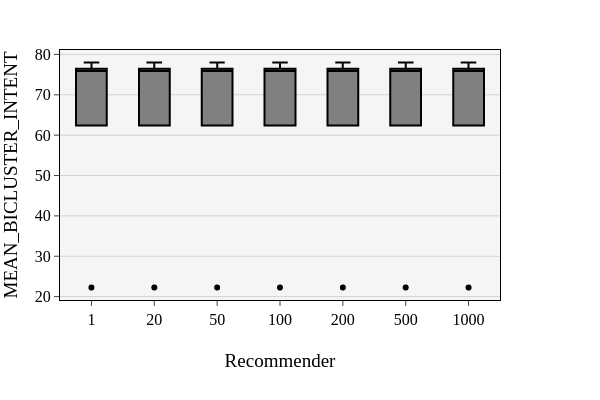

  Recommender       Mean  Standard Deviation    Variance       Min   Max     Median        Q1         Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  65.564103           21.669868  469.583169  22.25641  78.0  75.897436  75.74359  75.923077    75.474359    76.192308 -1.494388  0.242764
1          20  65.564103           21.669868  469.583169  22.25641  78.0  75.897436  75.74359  75.923077    75.474359    76.192308 -1.494388  0.242764
2          50  65.564103           21.669868  469.583169  22.25641  78.0  75.897436  75.74359  75.923077    75.474359    76.192308 -1.494388  0.242764
3         100  65.564103           21.669868  469.583169  22.25641  78.0  75.897436  75.74359  75.923077    75.474359    76.192308 -1.494388  0.242764
4         200  65.564103           21.669868  469.583169  22.25641  78.0  75.897436  75.74359  75.923077    75.474359    76.192308 -1.494388  0.242764
5         500  65.564103           21.669868  469.583169  22.25641  78.0  75.897436  75.74359 

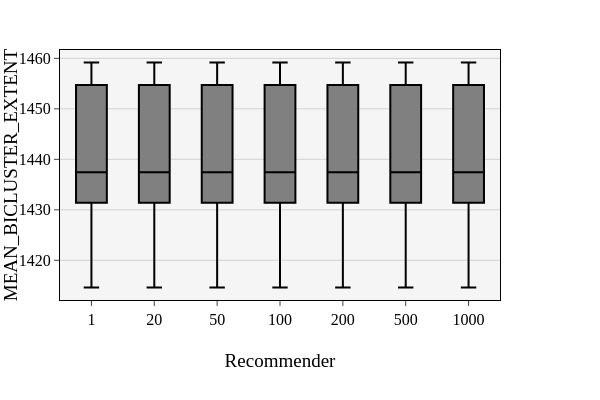

  Recommender         Mean  Standard Deviation    Variance          Min          Max       Median           Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  1440.292308           15.507777  240.491151  1414.615385  1459.179487  1437.461538  1436.974359  1453.230769  1412.589744  1477.615385 -0.433552 -0.959247
1          20  1440.292308           15.507777  240.491151  1414.615385  1459.179487  1437.461538  1436.974359  1453.230769  1412.589744  1477.615385 -0.433552 -0.959247
2          50  1440.292308           15.507777  240.491151  1414.615385  1459.179487  1437.461538  1436.974359  1453.230769  1412.589744  1477.615385 -0.433552 -0.959247
3         100  1440.292308           15.507777  240.491151  1414.615385  1459.179487  1437.461538  1436.974359  1453.230769  1412.589744  1477.615385 -0.433552 -0.959247
4         200  1440.292308           15.507777  240.491151  1414.615385  1459.179487  1437.461538  1436.974359  1453.230769  1412.589744  1477.615385 

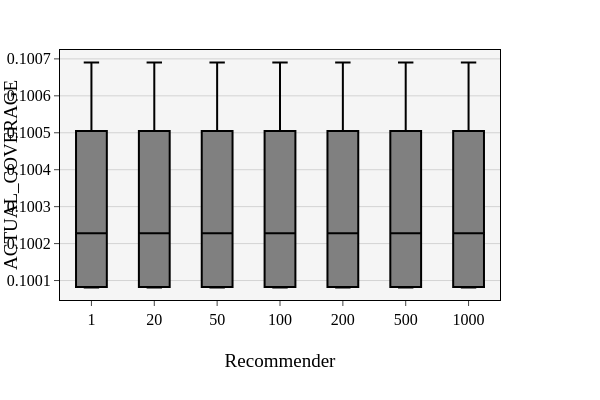

  Recommender      Mean  Standard Deviation      Variance       Min      Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0           1  0.100305            0.000233  5.449672e-08  0.100081  0.10069  0.100228  0.100083  0.100443     0.099544     0.100982  0.583696 -1.159601
1          20  0.100305            0.000233  5.449672e-08  0.100081  0.10069  0.100228  0.100083  0.100443     0.099544     0.100982  0.583696 -1.159601
2          50  0.100305            0.000233  5.449672e-08  0.100081  0.10069  0.100228  0.100083  0.100443     0.099544     0.100982  0.583696 -1.159601
3         100  0.100305            0.000233  5.449672e-08  0.100081  0.10069  0.100228  0.100083  0.100443     0.099544     0.100982  0.583696 -1.159601
4         200  0.100305            0.000233  5.449672e-08  0.100081  0.10069  0.100228  0.100083  0.100443     0.099544     0.100982  0.583696 -1.159601
5         500  0.100305            0.000233  5.449672e-08  0.100081  0.10069  0.10

In [6]:
import json
from evaluation.threads import GRECOND_BIAKNN_METIC_NAMES

with open('GreConD_IBPAKNN_sweep_knn_k.results', 'r') as file_object:
    results = json.load(file_object)

for metric_name in GRECOND_BIAKNN_METIC_NAMES:
    plot.plot_metric_box_plot(metric_name, results)
    print(plot.get_result_table(metric_name, results))

##### number_of_top_k_biclusters

In [ ]:
import json
from evaluation import threads
from recommenders import grecond_recommender
from dataset.movie_lens import load_ml_1m_folds
from dataset.movie_lens import resolve_folds

data, k_fold = load_ml_1m_folds()

best_params_user = {
    'grecond_coverage': 0.1,
    'dataset_binarization_threshold': 3.0,
    'minimum_bicluster_sparsity': None,
    'minimum_bicluster_coverage': None,
    'minimum_bicluster_relative_size': None,
    'user_binarization_threshold': 3.0,
    'number_of_top_k_biclusters': None,
    'knn_k': 100,
    'knn_type': 'item'
 }

folds = resolve_folds(data, k_fold)

numbers_of_top_k_biclusters = [None, 1, 5, 10, 50, 100, 200]

recommender_variations = [
    threads.RecommenderVariation(
        str(number_of_top_k_biclusters),
        grecond_recommender.GreConDBiAKNNRecommender(
            grecond_coverage=best_params_user['grecond_coverage'],
            dataset_binarization_threshold=best_params_user['dataset_binarization_threshold'],
            minimum_bicluster_sparsity=best_params_user["minimum_bicluster_sparsity"],
            minimum_bicluster_coverage=best_params_user["minimum_bicluster_coverage"],
            minimum_bicluster_relative_size=best_params_user["minimum_bicluster_relative_size"],
            knn_type=best_params_user["knn_type"],
            user_binarization_threshold=best_params_user["user_binarization_threshold"],
            number_of_top_k_biclusters=number_of_top_k_biclusters,
            knn_k=best_params_user['knn_k'],
        ),
    )
    for number_of_top_k_biclusters in numbers_of_top_k_biclusters
]

from evaluation.threads import grecond_biaknn_benchmark_thread

results = plot.benchmark(
    folds,
    recommender_variations,
    [],
    repeats=REPEAT,
    relevance_threshold=RELEVANCE_THRESHOLD,
    number_of_top_recommendations=NUMBER_OF_TOP_RECOMMENDATIONS,
    benchmark_thread=grecond_biaknn_benchmark_thread,
    thread_count=8
)

with open('GreConD_IBPAKNN_sweep_number_of_top_k_biclusters.results', 'w') as file_object:
    json.dump(results, file_object, indent=4)

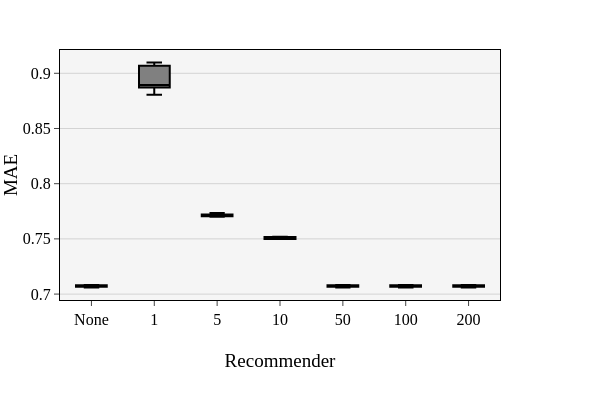

  Recommender      Mean  Standard Deviation      Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None  0.707284            0.000783  6.137597e-07  0.705972  0.708181  0.707528  0.706885  0.707853     0.705433     0.709305 -0.582317 -1.012210
1           1  0.895046            0.011027  1.215951e-04  0.880620  0.909775  0.889499  0.889349  0.905987     0.864392     0.930944  0.171169 -1.556693
2           5  0.771522            0.001177  1.386498e-06  0.770009  0.773536  0.771619  0.770775  0.771669     0.769433     0.773011  0.526498 -0.711698
3          10  0.750894            0.000867  7.516081e-07  0.749865  0.752054  0.751044  0.749949  0.751558     0.747537     0.753970 -0.023484 -1.612723
4          50  0.707284            0.000783  6.137597e-07  0.705972  0.708181  0.707528  0.706885  0.707853     0.705433     0.709305 -0.582317 -1.012210
5         100  0.707284            0.000783  6.137597e-07  0.705972  0.70818

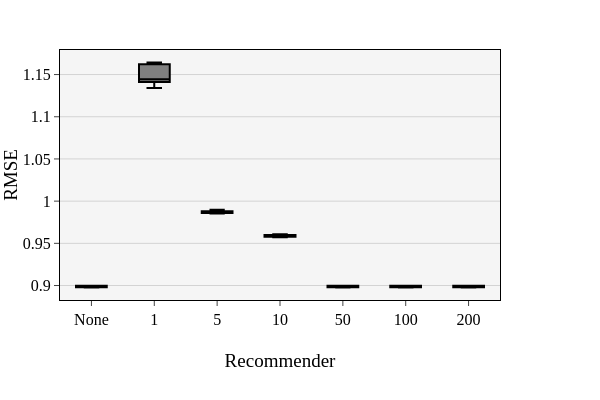

  Recommender      Mean  Standard Deviation      Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None  0.898812            0.000817  6.671090e-07  0.897656  0.899802  0.898758  0.898219  0.899626     0.896108     0.901737 -0.090431 -1.510918
1           1  1.149511            0.011510  1.324723e-04  1.134030  1.164281  1.144316  1.143518  1.161411     1.116678     1.188251  0.110360 -1.551331
2           5  0.987011            0.001471  2.165208e-06  0.985484  0.989692  0.986303  0.986194  0.987383     0.984412     0.989166  0.932425 -0.534107
3          10  0.958829            0.001219  1.484821e-06  0.957292  0.960815  0.958677  0.957956  0.959406     0.955782     0.961580  0.411333 -1.020012
4          50  0.898812            0.000817  6.671090e-07  0.897656  0.899802  0.898758  0.898219  0.899626     0.896108     0.901737 -0.090431 -1.510918
5         100  0.898812            0.000817  6.671090e-07  0.897656  0.89980

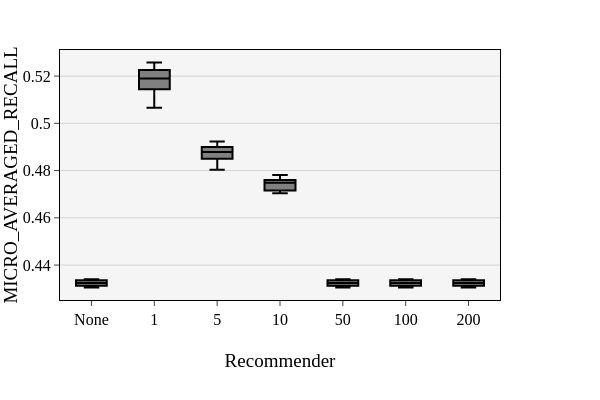

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None  0.432368            0.001247  0.000002  0.430506  0.433957  0.432389  0.431561  0.433430     0.428757     0.436233 -0.184027 -1.336461
1           1  0.517966            0.006402  0.000041  0.506574  0.525749  0.519024  0.516980  0.521504     0.510194     0.528290 -0.733466 -0.539718
2           5  0.487237            0.003953  0.000016  0.480316  0.492284  0.487822  0.486543  0.489218     0.482530     0.493231 -0.632226 -0.576003
3          10  0.474158            0.002705  0.000007  0.470433  0.478148  0.474887  0.471964  0.475356     0.466877     0.480443  0.034688 -1.237700
4          50  0.432368            0.001247  0.000002  0.430506  0.433957  0.432389  0.431561  0.433430     0.428757     0.436233 -0.184027 -1.336461
5         100  0.432368            0.001247  0.000002  0.430506  0.433957  0.432389  0.431561  0.433

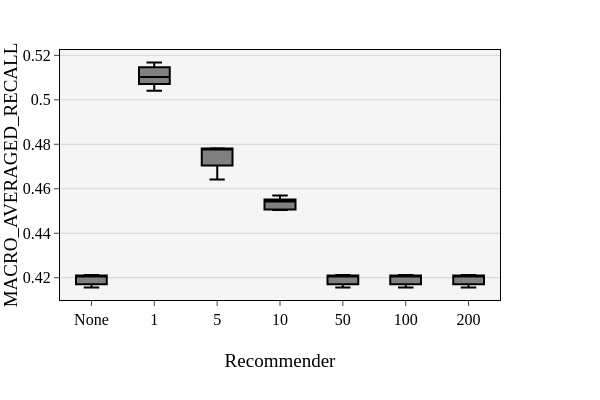

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None  0.419246            0.002254  0.000005  0.415605  0.421184  0.420849  0.417590  0.421001     0.412474     0.426116 -0.628450 -1.346639
1           1  0.510611            0.004427  0.000020  0.504051  0.516772  0.510305  0.508076  0.513850     0.499415     0.522511 -0.070823 -1.207055
2           5  0.474183            0.005463  0.000030  0.464115  0.478216  0.477870  0.472599  0.478115     0.464325     0.486389 -1.040587 -0.535814
3          10  0.453436            0.002474  0.000006  0.450489  0.456992  0.454286  0.450772  0.454638     0.444974     0.460436  0.038124 -1.459709
4          50  0.419246            0.002254  0.000005  0.415605  0.421184  0.420849  0.417590  0.421001     0.412474     0.426116 -0.628450 -1.346639
5         100  0.419246            0.002254  0.000005  0.415605  0.421184  0.420849  0.417590  0.421

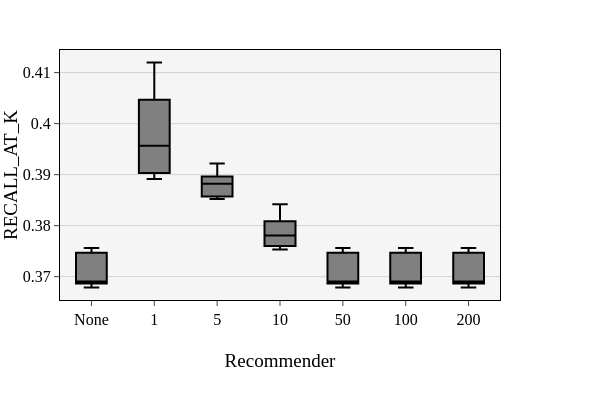

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None  0.371167            0.003175  0.000010  0.367878  0.375600  0.369033  0.368936  0.374390     0.360755     0.382571  0.400995 -1.707054
1           1  0.397956            0.008366  0.000070  0.389168  0.411984  0.395670  0.390721  0.402239     0.373443     0.419516  0.604394 -1.048568
2           5  0.388066            0.002462  0.000006  0.385250  0.392193  0.388236  0.385873  0.388777     0.381516     0.393134  0.506468 -0.951040
3          10  0.378720            0.003138  0.000010  0.375344  0.384211  0.378067  0.376229  0.379750     0.370947     0.385032  0.727280 -0.775723
4          50  0.371167            0.003175  0.000010  0.367878  0.375600  0.369033  0.368936  0.374390     0.360755     0.382571  0.400995 -1.707054
5         100  0.371167            0.003175  0.000010  0.367878  0.375600  0.369033  0.368936  0.374

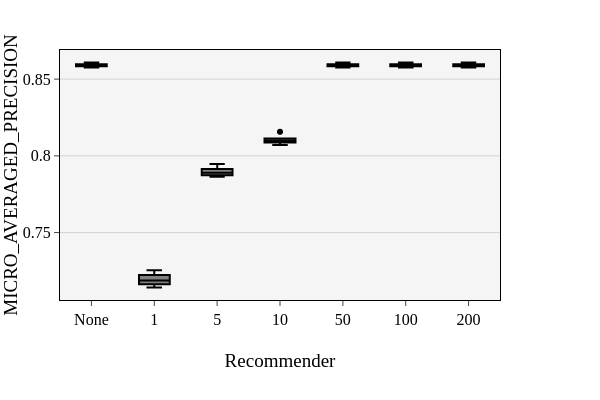

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None  0.859019            0.001078  0.000001  0.857502  0.860828  0.858984  0.858578  0.859203     0.857640     0.860141  0.375613 -0.618169
1           1  0.719364            0.003853  0.000015  0.714214  0.725503  0.718792  0.716964  0.721346     0.710390     0.727920  0.309877 -1.028347
2           5  0.789622            0.002821  0.000008  0.786436  0.794616  0.788999  0.787688  0.790370     0.783667     0.794392  0.759482 -0.662732
3          10  0.810372            0.002846  0.000008  0.807119  0.815688  0.809874  0.809290  0.809888     0.808394     0.810783  0.992090 -0.218630
4          50  0.859019            0.001078  0.000001  0.857502  0.860828  0.858984  0.858578  0.859203     0.857640     0.860141  0.375613 -0.618169
5         100  0.859019            0.001078  0.000001  0.857502  0.860828  0.858984  0.858578  0.859

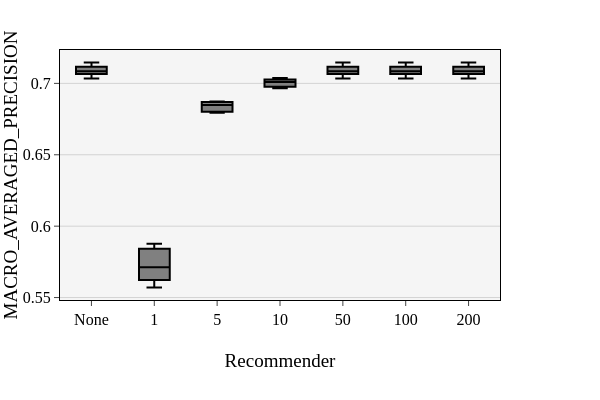

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None  0.708957            0.003658  0.000013  0.703504  0.714625  0.708459  0.707559  0.710640     0.702937     0.715262  0.088926 -0.845773
1           1  0.572634            0.011426  0.000131  0.557039  0.587689  0.571300  0.564103  0.583040     0.535697     0.611446  0.016395 -1.503051
2           5  0.683747            0.003289  0.000011  0.679402  0.687242  0.684776  0.680347  0.686967     0.670417     0.696897 -0.248105 -1.721503
3          10  0.700333            0.002687  0.000007  0.696635  0.703825  0.700950  0.697919  0.702338     0.691290     0.708967 -0.142261 -1.518944
4          50  0.708957            0.003658  0.000013  0.703504  0.714625  0.708459  0.707559  0.710640     0.702937     0.715262  0.088926 -0.845773
5         100  0.708957            0.003658  0.000013  0.703504  0.714625  0.708459  0.707559  0.710

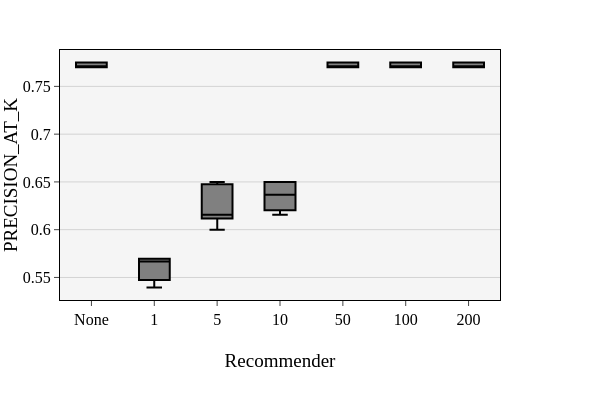

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None  0.772000            0.002449  0.000006  0.770000  0.775000  0.770000  0.770000  0.775000     0.762500     0.782500  0.408248 -1.833333
1           1  0.559006            0.012159  0.000148  0.539474  0.569444  0.566667  0.550000  0.569444     0.520833     0.598611 -0.607181 -1.359293
2           5  0.625583            0.019460  0.000379  0.600000  0.650000  0.615625  0.615625  0.646667     0.569062     0.693229  0.141354 -1.603994
3          10  0.634833            0.014144  0.000200  0.615625  0.650000  0.636667  0.621875  0.650000     0.579687     0.692188 -0.161105 -1.649972
4          50  0.772000            0.002449  0.000006  0.770000  0.775000  0.770000  0.770000  0.775000     0.762500     0.782500  0.408248 -1.833333
5         100  0.772000            0.002449  0.000006  0.770000  0.775000  0.770000  0.770000  0.775

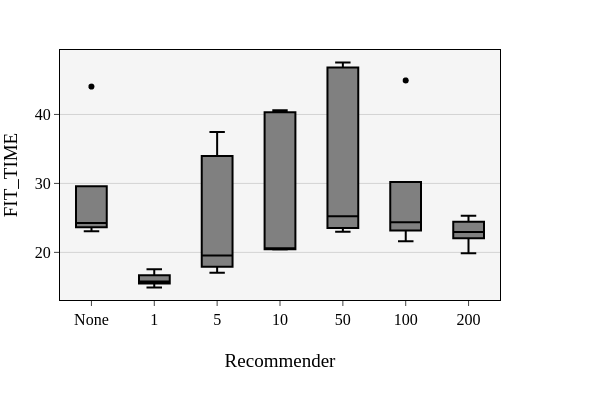

  Recommender       Mean  Standard Deviation    Variance        Min        Max     Median         Q1         Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None  27.991473            8.043113   64.691659  23.079047  44.039185  24.249503  23.812952  24.776676    22.367365    26.222263  1.482015  0.226338
1           1  16.054745            0.878613    0.771960  14.905196  17.540733  15.768456  15.678273  16.381066    14.624083    17.435256  0.507226 -0.764682
2           5  25.004043            8.431679   71.093214  17.041333  37.448884  19.536714  18.188760  32.804522    -3.734883    54.728166  0.472833 -1.624543
3          10  28.450262            9.767508   95.404212  20.403872  40.606026  20.548794  20.474863  40.217754    -9.139473    69.832090  0.408665 -1.832243
4          50  33.202599           11.324184  128.237137  22.987557  47.533072  25.229680  23.719319  46.543368   -10.516755    80.779443  0.398255 -1.821920
5         100  27.974370            8.564135   73.34

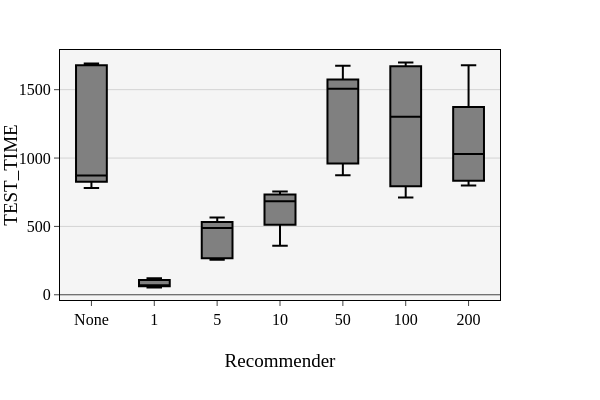

  Recommender         Mean  Standard Deviation       Variance         Min          Max       Median          Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None  1172.068414          418.291401  174967.695998  780.054759  1692.391209   872.399970  841.848571  1673.647562  -405.849915  2921.346048  0.393226 -1.822996
1           1    81.797669           25.633376     657.069982   53.244424   120.247900    66.675756   65.054003   103.766264     6.985610   161.834656  0.427680 -1.511038
2           5   420.345279          130.367771   16995.755649  255.789081   564.403371   489.195148  271.193297   521.145497  -103.735003   896.073797 -0.309960 -1.764405
3          10   617.529401          145.147227   21067.717618  358.612165   755.189042   684.290595  562.898756   726.656446   317.262222   972.292981 -0.870826 -0.736251
4          50  1317.114583          321.723412  103505.953782  873.571676  1674.759196  1507.187513  989.949191  1540.105338   164.714971  2365.3

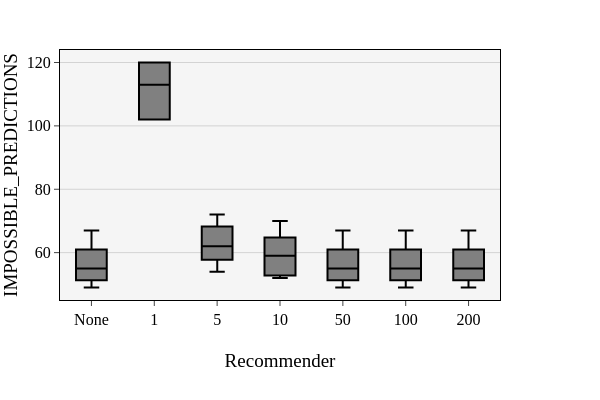

  Recommender   Mean  Standard Deviation  Variance  Min  Max  Median     Q1     Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None   56.4            6.248200     39.04   49   67    55.0   52.0   59.0         41.5         69.5  0.586595 -0.894161
1           1  111.4            8.089499     65.44  102  120   113.0  102.0  120.0         75.0        147.0 -0.145439 -1.759493
2           5   62.8            6.241795     38.96   54   72    62.0   59.0   67.0         47.0         79.0  0.095337 -1.197359
3          10   59.4            6.651316     44.24   52   70    59.0   53.0   63.0         38.0         78.0  0.387583 -1.214865
4          50   56.4            6.248200     39.04   49   67    55.0   52.0   59.0         41.5         69.5  0.586595 -0.894161
5         100   56.4            6.248200     39.04   49   67    55.0   52.0   59.0         41.5         69.5  0.586595 -0.894161
6         200   56.4            6.248200     39.04   49   67    55.0   52.0   59.0         41.5  

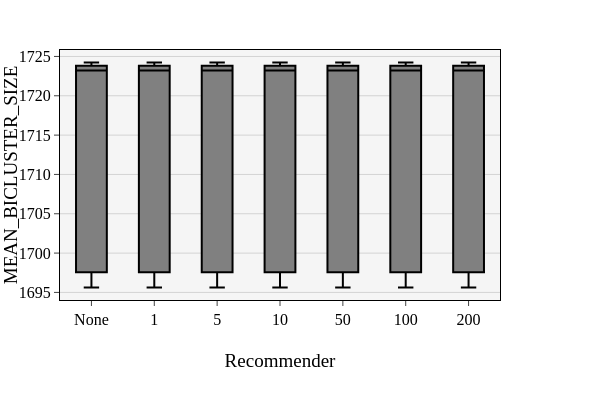

  Recommender         Mean  Standard Deviation   Variance       Min          Max       Median      Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None  1712.990641           13.156979  173.10609  1695.625  1724.230769  1723.205128  1698.2  1723.692308  1659.961538  1761.930769 -0.418088 -1.806883
1           1  1712.990641           13.156979  173.10609  1695.625  1724.230769  1723.205128  1698.2  1723.692308  1659.961538  1761.930769 -0.418088 -1.806883
2           5  1712.990641           13.156979  173.10609  1695.625  1724.230769  1723.205128  1698.2  1723.692308  1659.961538  1761.930769 -0.418088 -1.806883
3          10  1712.990641           13.156979  173.10609  1695.625  1724.230769  1723.205128  1698.2  1723.692308  1659.961538  1761.930769 -0.418088 -1.806883
4          50  1712.990641           13.156979  173.10609  1695.625  1724.230769  1723.205128  1698.2  1723.692308  1659.961538  1761.930769 -0.418088 -1.806883
5         100  1712.990641        

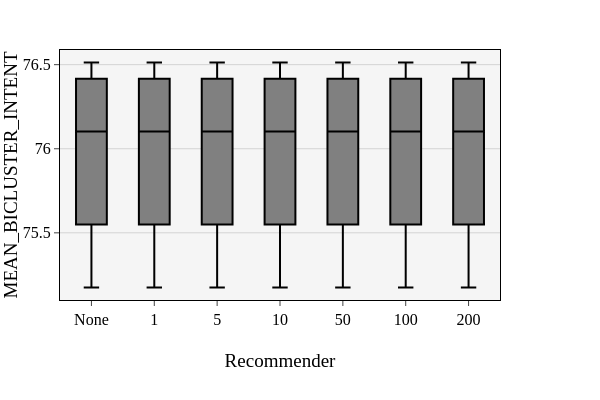

  Recommender   Mean  Standard Deviation  Variance     Min        Max     Median      Q1         Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None  75.97            0.490547  0.240637  75.175  76.512821  76.102564  75.675  76.384615    74.610577    77.449038 -0.499109  -1.19117
1           1  75.97            0.490547  0.240637  75.175  76.512821  76.102564  75.675  76.384615    74.610577    77.449038 -0.499109  -1.19117
2           5  75.97            0.490547  0.240637  75.175  76.512821  76.102564  75.675  76.384615    74.610577    77.449038 -0.499109  -1.19117
3          10  75.97            0.490547  0.240637  75.175  76.512821  76.102564  75.675  76.384615    74.610577    77.449038 -0.499109  -1.19117
4          50  75.97            0.490547  0.240637  75.175  76.512821  76.102564  75.675  76.384615    74.610577    77.449038 -0.499109  -1.19117
5         100  75.97            0.490547  0.240637  75.175  76.512821  76.102564  75.675  76.384615    74.610577    77.44903

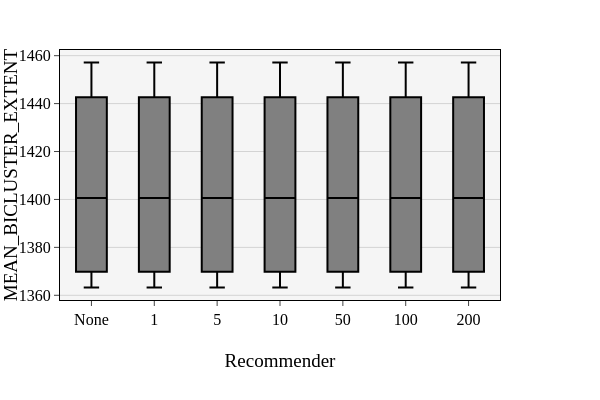

  Recommender         Mean  Standard Deviation     Variance      Min          Max       Median        Q1           Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None  1406.188333           36.449778  1328.586334  1363.25  1457.153846  1400.641026  1372.025  1437.871795  1273.254808  1536.641987  0.185757 -1.581757
1           1  1406.188333           36.449778  1328.586334  1363.25  1457.153846  1400.641026  1372.025  1437.871795  1273.254808  1536.641987  0.185757 -1.581757
2           5  1406.188333           36.449778  1328.586334  1363.25  1457.153846  1400.641026  1372.025  1437.871795  1273.254808  1536.641987  0.185757 -1.581757
3          10  1406.188333           36.449778  1328.586334  1363.25  1457.153846  1400.641026  1372.025  1437.871795  1273.254808  1536.641987  0.185757 -1.581757
4          50  1406.188333           36.449778  1328.586334  1363.25  1457.153846  1400.641026  1372.025  1437.871795  1273.254808  1536.641987  0.185757 -1.581757
5         100  1

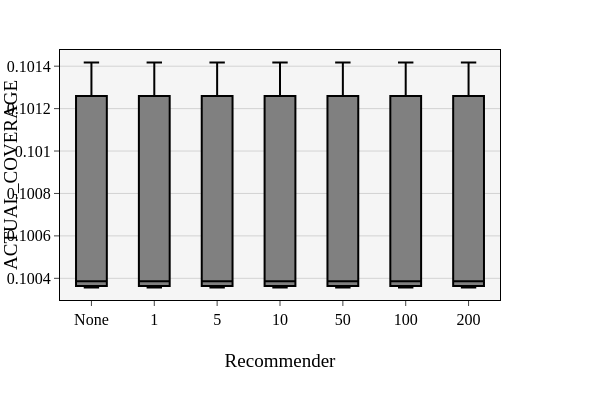

  Recommender      Mean  Standard Deviation      Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        None  0.100747            0.000467  2.179358e-07  0.100357  0.101417  0.100386  0.100365  0.101207     0.099103      0.10247  0.468265 -1.700038
1           1  0.100747            0.000467  2.179358e-07  0.100357  0.101417  0.100386  0.100365  0.101207     0.099103      0.10247  0.468265 -1.700038
2           5  0.100747            0.000467  2.179358e-07  0.100357  0.101417  0.100386  0.100365  0.101207     0.099103      0.10247  0.468265 -1.700038
3          10  0.100747            0.000467  2.179358e-07  0.100357  0.101417  0.100386  0.100365  0.101207     0.099103      0.10247  0.468265 -1.700038
4          50  0.100747            0.000467  2.179358e-07  0.100357  0.101417  0.100386  0.100365  0.101207     0.099103      0.10247  0.468265 -1.700038
5         100  0.100747            0.000467  2.179358e-07  0.100357  0.10141

In [7]:
import json
from evaluation.threads import GRECOND_BIAKNN_METIC_NAMES

with open('GreConD_IBPAKNN_sweep_number_of_top_k_biclusters.results', 'r') as file_object:
    results = json.load(file_object)

for metric_name in GRECOND_BIAKNN_METIC_NAMES:
    plot.plot_metric_box_plot(metric_name, results)
    print(plot.get_result_table(metric_name, results))